In [1]:
import os
import json
import csv

def create_data_list(base_directory, expected_output_file_name):
    base_dir = os.path.join(os.getcwd(), base_directory)
    
    rows = []
    for instance_dir in os.listdir(base_dir):
        instance_path = os.path.join(base_dir, instance_dir)
        
        if os.path.isdir(instance_path):
            image_files = [file for file in os.listdir(instance_path) if file.endswith(('.png', '.jpg', '.jpeg'))]
            json_path = os.path.join(instance_path,expected_output_file_name)
            if os.path.exists(json_path):
                with open(json_path, "r") as json_file:
                    expected_output = json.load(json_file)
            else:
                expected_output = None
            rows.append([instance_dir, image_files, json.dumps(expected_output, ensure_ascii=False)])
    return rows

def create_output_csv(data_source_file):
    output_csv = data_source_file
    with open(output_csv, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["instance_path", "image_files", "expected_output"])
        rows = create_data_list("../test_data/labels", "expected_output.json")
        for row in rows:
            writer.writerow(row)
    print(f"CSV file '{output_csv}' created successfully.")


In [2]:
create_output_csv("test_data.csv")

CSV file 'test_data.csv' created successfully.


# Importing DSPy related modules.
The first cell after this cell is just for notebook use, not in source code.

In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [4]:
from dotenv import load_dotenv
import dspy
from pipeline_new.components.label import LabelStorage
from pipeline_new.components.ocr import OCR
from pipeline_new.schemas.inspection import FertilizerInspection

/opt/homebrew/Caskroom/miniforge/base/envs/fertiscan-pipeline/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
SUPPORTED_MODELS = {
    "gpt-3.5-turbo": {
        "max_tokens": 12000,
        "api_version": "2024-02-01",
        "response_format": {"type": "json_object"},
    },
    "gpt-4o": {
        "max_tokens": None,
        "api_version": "2024-02-15-preview",
        "response_format": {"type": "json_object"},
    },
}

REQUIREMENTS = """
The content of keys with the suffix _en must be in English.
The content of keys with the suffix _fr must be in French.
Translation of the text is prohibited.
You are prohibited from generating any text that is not part of the JSON.
The JSON must contain exclusively keys specified in "keys".
"""

# Signatures
class Inspector(dspy.Signature):
    """
    You are a fertilizer label inspector working for the Canadian Food Inspection Agency.
    Your task is to classify all information present in the provided text using the specified keys.
    Your response should be accurate, intelligible, information in JSON, and contain all the text from the provided text.
    """

    text: str = dspy.InputField(
        desc="The text of the fertilizer label extracted using OCR."
    )

    # TODO remove the depency on the pseudo prompt engineering
    requirements: str = dspy.InputField(
        desc="The instructions and guidelines to follow."
    )

    inspection: FertilizerInspection = dspy.OutputField(desc="The inspection results.")

class LanguageProgram(dspy.Module):
    def __init__(self, azure_openai_key, azure_openai_endpoint, azure_ocr_key, azure_ocr_endpoint, deployment_id):
        # initialize all the components to be used in the forward method
        lm = dspy.LM(
            model=f"azure/{deployment_id}",
            api_base=azure_openai_endpoint,
            api_key=azure_openai_key,
            max_tokens=SUPPORTED_MODELS.get(deployment_id)["max_tokens"],
            api_version=SUPPORTED_MODELS.get(deployment_id)["api_version"],
        )
        dspy.configure(lm=lm)
        self.ocr = OCR(azure_ocr_endpoint, azure_ocr_key)
        self.label_storage = LabelStorage()
        self.inspector = dspy.TypedChainOfThought(Inspector)

    def forward(self, image_paths):
        print("loading images...")
        for image_path in image_paths:
            self.label_storage.add_image(image_path)

        print("turning images into pdfs...")
        document = self.label_storage.get_document()
        
        print("sending the pdf to ocr...")
        ocr_results = self.ocr.extract_text(document=document)

        print("sending the text to llm...")
        inspection = self.inspector(text=ocr_results.content, requirements=REQUIREMENTS)

        print("done")
        # self.label_storage.clear()

        return inspection

In [6]:
SUPPORTED_MODELS = {
    "gpt-3.5-turbo": {
        "max_tokens": 12000,
        "api_version": "2024-02-01",
        "response_format": {"type": "json_object"},
    },
    "gpt-4o": {
        "max_tokens": None,
        "api_version": "2024-02-15-preview",
        "response_format": {"type": "json_object"},
    },
}

REQUIREMENTS = """
The content of keys with the suffix _en must be in English.
The content of keys with the suffix _fr must be in French.
Translation of the text is prohibited.
You are prohibited from generating any text that is not part of the JSON.
The JSON must contain exclusively keys specified in "keys".
"""

# Signatures
class Inspector(dspy.Signature):
    """
    You are a fertilizer label inspector working for the Canadian Food Inspection Agency.
    Your task is to classify all information present in the provided text using the specified keys.
    Your response should be accurate, intelligible, information in JSON, and contain all the text from the provided text.
    """

    text: str = dspy.InputField(
        desc="The text of the fertilizer label extracted using OCR."
    )

    # TODO remove the depency on the pseudo prompt engineering
    requirements: str = dspy.InputField(
        desc="The instructions and guidelines to follow."
    )

    inspection: FertilizerInspection = dspy.OutputField(desc="The inspection results.")

class LanguageProgram(dspy.Module):
    def __init__(self, azure_openai_key, azure_openai_endpoint, azure_ocr_key, azure_ocr_endpoint, deployment_id):
        # initialize all the components to be used in the forward method
        lm = dspy.LM(
            model=f"azure/{deployment_id}",
            api_base=azure_openai_endpoint,
            api_key=azure_openai_key,
            max_tokens=SUPPORTED_MODELS.get(deployment_id)["max_tokens"],
            api_version=SUPPORTED_MODELS.get(deployment_id)["api_version"],
        )
        dspy.configure(lm=lm)
        self.ocr = OCR(azure_ocr_endpoint, azure_ocr_key)
        self.label_storage = LabelStorage()
        self.inspector = dspy.TypedChainOfThought(Inspector)

    def forward(self, image_paths):
        print("loading images...")
        for image_path in image_paths:
            self.label_storage.add_image(image_path)

        print("turning images into pdfs...")
        document = self.label_storage.get_document()
        
        print("sending the pdf to ocr...")
        ocr_results = self.ocr.extract_text(document=document)

        print("sending the text to llm...")
        inspection = self.inspector(text=ocr_results.content, requirements=REQUIREMENTS)

        print("done")
        # self.label_storage.clear()

        return inspection

In [7]:
from ast import literal_eval

def call_dspy(images, instance):
    load_dotenv()    

    required_vars = [
        "AZURE_API_ENDPOINT",
        "AZURE_API_KEY",
        "AZURE_OPENAI_ENDPOINT",
        "AZURE_OPENAI_KEY",
        "AZURE_OPENAI_DEPLOYMENT",
    ]
    missing_vars = [var for var in required_vars if not os.getenv(var)]
    if missing_vars:
        raise RuntimeError(f"Missing required environment variables: {', '.join(missing_vars)}")

    AZURE_API_ENDPOINT = os.getenv('AZURE_API_ENDPOINT')
    AZURE_API_KEY = os.getenv('AZURE_API_KEY')
    AZURE_OPENAI_ENDPOINT = os.getenv('AZURE_OPENAI_ENDPOINT')
    AZURE_OPENAI_KEY = os.getenv('AZURE_OPENAI_KEY')
    AZURE_OPENAI_DEPLOYMENT = os.getenv('AZURE_OPENAI_DEPLOYMENT')

    images_path = []
    images = literal_eval(images)
    for image in images:
        file_path = "../test_data/labels/" + instance + "/" + image
        full_path = os.path.join(os.getcwd(), file_path)
        images_path.append(full_path)

    language_program = LanguageProgram(AZURE_OPENAI_KEY, AZURE_OPENAI_ENDPOINT,AZURE_API_KEY,AZURE_API_ENDPOINT, AZURE_OPENAI_DEPLOYMENT)

    inspection = language_program.forward(images_path)

    return inspection.inspection

In [8]:
import pandas as pd

df = pd.read_csv('test_data.csv')

In [9]:
df.head()

,instance_path,image_files,expected_output
0,label_004,['img_001.png'],"{""company_name"": ""Evergreen liquid plant food ..."
1,label_003,['img_001.png'],"{""company_name"": ""Novago Coopérative"", ""compan..."
2,label_035,"['img_001.png', 'img_002.png']","{""company_name"": ""Gloco"", ""company_address"": ""..."
3,label_032,"['img_001.png', 'img_003.png', 'img_002.png']","{""company_name"": ""Novago Coopérative"", ""compan..."
4,label_033,"['img_001.png', 'img_002.png']","{""company_name"": ""La Coop fédérée"", ""company_a..."


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   instance_path    35 non-null     object
 1   image_files      35 non-null     object
 2   expected_output  35 non-null     object
dtypes: object(3)
memory usage: 972.0+ bytes


In [ ]:
def process_row(row):
    try:
        print(row['instance_path'])
        # Call your function and process the row
        inspection_dict = call_dspy(row['image_files'], row['instance_path']).dict()
        return json.dumps(inspection_dict, ensure_ascii=False)
    except Exception as e:
        # Print the error for debugging and return None
        print(f"Error processing row with instance_path {row['instance_path']}: {e}")
        return None
    
df['dspy_output'] = df.apply(process_row, axis=1)

In [11]:
# df.to_csv('test_data_output.csv', index=False)
df = pd.read_csv('test_data_output.csv')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   instance_path    35 non-null     object
 1   image_files      35 non-null     object
 2   expected_output  35 non-null     object
 3   dspy_output      35 non-null     object
dtypes: object(4)
memory usage: 1.2+ KB


In [13]:
def flatten_jsons(df, json_columns):
    for col in json_columns:
        df[col] = df[col].apply(json.loads)
        flattened_col1 = pd.json_normalize(df[col], max_level=0)
        df = pd.concat([df, flattened_col1.add_prefix(col + "_")], axis=1)
    return df

In [14]:
df_flatten = df.copy()

df_flatten = flatten_jsons(df_flatten, ['expected_output', 'dspy_output'])

In [15]:
df_flatten.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 50 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   instance_path                              35 non-null     object
 1   image_files                                35 non-null     object
 2   expected_output                            35 non-null     object
 3   dspy_output                                35 non-null     object
 4   expected_output_company_name               33 non-null     object
 5   expected_output_company_address            32 non-null     object
 6   expected_output_company_website            16 non-null     object
 7   expected_output_company_phone_number       13 non-null     object
 8   expected_output_manufacturer_name          6 non-null      object
 9   expected_output_manufacturer_address       6 non-null      object
 10  expected_output_manufacturer_website    

In [16]:
df_flatten.head()

,instance_path,image_files,expected_output,dspy_output,expected_output_company_name,expected_output_company_address,expected_output_company_website,expected_output_company_phone_number,expected_output_manufacturer_name,expected_output_manufacturer_address,...,dspy_output_volume,dspy_output_npk,dspy_output_guaranteed_analysis_en,dspy_output_guaranteed_analysis_fr,dspy_output_cautions_en,dspy_output_cautions_fr,dspy_output_instructions_en,dspy_output_instructions_fr,dspy_output_ingredients_en,dspy_output_ingredients_fr
0,label_004,['img_001.png'],{'company_name': 'Evergreen liquid plant food ...,{'company_name': 'Evergreen Liquid Plant Food ...,Evergreen liquid plant food ltd,"790 st charles street x. rr1, Breslau, Ontario...",None,None,None,None,...,None,8-16-8,"{'title': 'Guaranteed Minimum Analysis', 'nutr...",None,[],[],"[For use on all field, fruit and vegetable cro...",[],[],[]
1,label_003,['img_001.png'],"{'company_name': 'Novago Coopérative', 'compan...","{'company_name': 'Novago Coopérative', 'compan...",Novago Coopérative,"839, rue papineau, Joliette, QC J6E 2L6",None,None,None,None,...,None,15-22-6,None,"{'title': 'ANALYSE GARANTIE MINIMALE', 'nutrie...",[],"[Cet engrais renferme du B,ZN et ne doit être ...",[],[],[],[]
2,label_035,"['img_001.png', 'img_002.png']","{'company_name': 'Gloco', 'company_address': '...","{'company_name': '9288-3354 Quebec inc.', 'com...",Gloco,"26, route Maritime, Forestville, Quebec G0T 1E0",http://bionik.ca,None,None,None,...,None,0.6-1.8-0.13,"{'title': 'GUARANTEED MINIMUM ANALYSIS', 'nutr...","{'title': 'ANALYSE MINIMUM GARANTIE', 'nutrien...",[CONTAINS NO PEAT MOSS OR ANIMAL MANURE.],[NE CONTIENT NI TOURBE NI FUMIER ANIMAL.],[Vegetable gardens and flower beds: Spread a 0...,"[Potager et plates-bandes: Épandre 0,6 mm (1/4...","[{'nutrient': 'Barks', 'value': None, 'unit': ...","[{'nutrient': 'Écorces', 'value': None, 'unit'..."
3,label_032,"['img_001.png', 'img_003.png', 'img_002.png']","{'company_name': 'Novago Coopérative', 'compan...","{'company_name': 'Sollio Agriculture', 'compan...",Novago Coopérative,"60 rue Fenne, St-Jacques, Québec, JOK 2R0",None,None,Sollio Agriculture,"Montréal, Québec H4N 3H7",...,None,9-11-12,None,"{'title': 'ANALYSE MINIMALE GARANTIE', 'nutrie...","[Danger! Eye and skin irritant., Precautionary...",[AVERTISSEMENT : Cet engrais doit être employé...,[REFER TO MATERIAL SAFETY DATA SHEET],[CONSULTER LA FICHE SIGNALITIQUE],[],[]
4,label_033,"['img_001.png', 'img_002.png']","{'company_name': 'La Coop fédérée', 'company_a...","{'company_name': 'La Coop fédérée', 'company_a...",La Coop fédérée,"4225, rue Saint-Joseph, Trois-Rivières (Québec...",None,None,None,None,...,None,2-14-0,"{'title': 'GUARANTEED MINIMUM ANALYSIS', 'nutr...","{'title': 'ANALYSE MINIMALE GARANTIE', 'nutrie...","[Feeding this product to cattle, sheep, deer o...","[boeufs, moutons, cerfs et autres ruminants. D...",[Spread fertilizer evenly at the base of plant...,[Épandre l'engrais uniformément au pied des pl...,[],[]


In [17]:
df_flatten.isna().sum()

instance_path                                 0
image_files                                   0
expected_output                               0
dspy_output                                   0
expected_output_company_name                  2
expected_output_company_address               3
expected_output_company_website              19
expected_output_company_phone_number         22
expected_output_manufacturer_name            29
expected_output_manufacturer_address         29
expected_output_manufacturer_website         35
expected_output_manufacturer_phone_number    33
expected_output_fertiliser_name               1
expected_output_registration_number          23
expected_output_lot_number                   28
expected_output_weight                        0
expected_output_density                       0
expected_output_volume                        0
expected_output_npk                          15
expected_output_guaranteed_analysis_en        0
expected_output_guaranteed_analysis_fr  

## test

In [20]:
def flatten_jsons2(df, json_columns):
    for col in json_columns:
        df[col] = df[col].apply(json.loads)
        flattened_col1 = pd.json_normalize(df[col])
        df = pd.concat([df, flattened_col1.add_prefix(col + "_")], axis=1)
    return df

df_flatten2 = df.copy()

df_flatten2 = flatten_jsons2(df_flatten2, ['expected_output', 'dspy_output'])



In [21]:
df_flatten2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 64 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   instance_path                                     35 non-null     object 
 1   image_files                                       35 non-null     object 
 2   expected_output                                   35 non-null     object 
 3   dspy_output                                       35 non-null     object 
 4   expected_output_company_name                      33 non-null     object 
 5   expected_output_company_address                   32 non-null     object 
 6   expected_output_company_website                   16 non-null     object 
 7   expected_output_company_phone_number              13 non-null     object 
 8   expected_output_manufacturer_name                 6 non-null      object 
 9   expected_output_manufac

In [22]:
for column in df_flatten2.columns:
    if column not in df_flatten.columns:
        print(column)

expected_output_density.value
expected_output_density.unit
expected_output_volume.value
expected_output_volume.unit
expected_output_guaranteed_analysis_en.title
expected_output_guaranteed_analysis_en.nutrients
expected_output_guaranteed_analysis_fr.title
expected_output_guaranteed_analysis_fr.nutrients
dspy_output_guaranteed_analysis_en.title
dspy_output_guaranteed_analysis_en.nutrients
dspy_output_guaranteed_analysis_en.is_minimal
dspy_output_density.value
dspy_output_density.unit
dspy_output_guaranteed_analysis_fr.title
dspy_output_guaranteed_analysis_fr.nutrients
dspy_output_guaranteed_analysis_fr.is_minimal
dspy_output_volume.value
dspy_output_volume.unit


In [100]:
df_flatten2.to_csv('flat_data.csv', index=False)

# company_name

In [156]:
(df_flatten['expected_output_company_name'].isna().sum())

np.int64(2)

In [157]:
(df_flatten['dspy_output_company_name'].isna().sum())

np.int64(0)

In [159]:
df_flatten[df_flatten['expected_output_company_name'].isna()][['instance_path', 'expected_output_company_name', 'dspy_output_company_name']]

,instance_path,expected_output_company_name,dspy_output_company_name
18,label_026,None,ETI MADEN MINES AND PRODUCTS
33,label_025,None,"Stoller Enterprises, Inc."


In [23]:
exact_match_num = len(df_flatten[df_flatten['expected_output_company_name'] == df_flatten['dspy_output_company_name']])
print("There are " + str(exact_match_num) + " instances with the exact same company name")
print("Percentage of exact matches: " + str(exact_match_num/len(df_flatten[df_flatten['expected_output_company_name'].notna()]) * 100) + "%")

There are 15 instances with the exact same company name
Percentage of exact matches: 45.45454545454545%


In [24]:
not_match = df_flatten[df_flatten['expected_output_company_name'] != df_flatten['dspy_output_company_name']]

In [25]:
not_match[['instance_path', 'expected_output_company_name', 'dspy_output_company_name']]

,instance_path,expected_output_company_name,dspy_output_company_name
0,label_004,Evergreen liquid plant food ltd,Evergreen Liquid Plant Food Ltd.
2,label_035,Gloco,9288-3354 Quebec inc.
3,label_032,Novago Coopérative,Sollio Agriculture
6,label_002,synagri,synAgri
7,label_005,"K.T Sunny, inc","K.T. Sunny, Inc."
8,label_027,Synagri s.e.c./l.p,Synagri s.e.c./1.p.
9,label_018,PREMIER TECH HOME & GARDEN INC.,Premier Tech Home & Garden Inc.
12,label_029,Synagri s.e.c./l.p.,Synagri s.e.c./I.p.
15,label_017,PREMIER TECH HOME & GARDEN INC.,Premier Tech Home & Garden Inc.
16,label_028,"Cameron Chemicals, Inc","Cameron Chemicals, Inc."


In [260]:
import re

def preprocess_string(input_string):
    """
    Preprocesses a string by:
    1. Converting to lowercase.
    2. Removing extra whitespace, punctuation, and special characters.

    Args:
        input_string (str): The input string to preprocess.

    Returns:
        str: The preprocessed string.
    """
    # if input_string is None:
    #     return None
    # if not isinstance(input_string, str):
    #     input_string = str(input_string)
    # lowercased = input_string.lower()
    # cleaned = re.sub(r'[^a-z0-9\s]', '', lowercased)
    # cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    # return cleaned
    if input_string is None:
        return None
    if not isinstance(input_string, str):
        input_string = str(input_string)
    lowercased = input_string.lower()
    cleaned = re.sub(r'[^\w\s]', '', lowercased, flags=re.UNICODE)
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    return cleaned

In [27]:
df_flatten['expected_output_company_name_cleaned'] = df_flatten['expected_output_company_name'].apply(preprocess_string)
df_flatten['dspy_output_company_name_cleaned'] = df_flatten['dspy_output_company_name'].apply(preprocess_string)

In [28]:
exact_match_num = len(df_flatten[df_flatten['expected_output_company_name_cleaned'] == df_flatten['dspy_output_company_name_cleaned']])
print("There are " + str(exact_match_num) + " instances with the exact same company name")
print("Percentage of exact matches: " + str(exact_match_num/len(df_flatten[df_flatten['expected_output_company_name'].notna()]) * 100) + "%")

There are 22 instances with the exact same company name
Percentage of exact matches: 66.66666666666666%


In [29]:
df_flatten[df_flatten['expected_output_company_name_cleaned'] != df_flatten['dspy_output_company_name_cleaned']][['instance_path', 'expected_output_company_name_cleaned', 'dspy_output_company_name_cleaned']]

,instance_path,expected_output_company_name_cleaned,dspy_output_company_name_cleaned
2,label_035,gloco,92883354 quebec inc
3,label_032,novago cooprative,sollio agriculture
8,label_027,synagri seclp,synagri sec1p
12,label_029,synagri seclp,synagri secip
17,label_021,big blue,lep
18,label_026,None,eti maden mines and products
24,label_030,amp advanced micronutrient product inc,advanced micronutrient products inc
26,label_001,natures aid,diamond fertilizers inc
28,label_024,matriaux paysagers savaria lte,savaria matriaux paysagers savaria lte
29,label_012,contrecoeur synagri,synagri lpsec


Score

In [30]:
!pip install jellyfish

In [31]:
import jellyfish

In [32]:
company_name = df_flatten[df_flatten['expected_output_company_name'].notna()]
print(len(company_name))

company_name = company_name[['instance_path', 'expected_output_company_name', 'dspy_output_company_name', 'expected_output_company_name_cleaned', 'dspy_output_company_name_cleaned']]

company_name.head()

33


,instance_path,expected_output_company_name,dspy_output_company_name,expected_output_company_name_cleaned,dspy_output_company_name_cleaned
0,label_004,Evergreen liquid plant food ltd,Evergreen Liquid Plant Food Ltd.,evergreen liquid plant food ltd,evergreen liquid plant food ltd
1,label_003,Novago Coopérative,Novago Coopérative,novago cooprative,novago cooprative
2,label_035,Gloco,9288-3354 Quebec inc.,gloco,92883354 quebec inc
3,label_032,Novago Coopérative,Sollio Agriculture,novago cooprative,sollio agriculture
4,label_033,La Coop fédérée,La Coop fédérée,la coop fdre,la coop fdre


In [33]:
company_name['company_name_jw_score'] = company_name.apply(lambda x: jellyfish.jaro_winkler_similarity(x['expected_output_company_name'], x['dspy_output_company_name']), axis=1)
company_name['company_name_cleaned_jw_score'] = company_name.apply(lambda x: jellyfish.jaro_winkler_similarity(x['expected_output_company_name_cleaned'], x['dspy_output_company_name_cleaned']), axis=1)
company_name.head()

,instance_path,expected_output_company_name,dspy_output_company_name,expected_output_company_name_cleaned,dspy_output_company_name_cleaned,company_name_jw_score,company_name_cleaned_jw_score
0,label_004,Evergreen liquid plant food ltd,Evergreen Liquid Plant Food Ltd.,evergreen liquid plant food ltd,evergreen liquid plant food ltd,0.920721,1.000000
1,label_003,Novago Coopérative,Novago Coopérative,novago cooprative,novago cooprative,1.000000,1.000000
2,label_035,Gloco,9288-3354 Quebec inc.,gloco,92883354 quebec inc,0.000000,0.000000
3,label_032,Novago Coopérative,Sollio Agriculture,novago cooprative,sollio agriculture,0.546296,0.581264
4,label_033,La Coop fédérée,La Coop fédérée,la coop fdre,la coop fdre,1.000000,1.000000


In [34]:
print("Average Jaro-Winkler similarity score for company names: " + str(company_name['company_name_jw_score'].mean()))
print("Average Jaro-Winkler similarity score for cleaned company names: " + str(company_name['company_name_cleaned_jw_score'].mean()))

Average Jaro-Winkler similarity score for company names: 0.8011290953152095
Average Jaro-Winkler similarity score for cleaned company names: 0.8495930911392533


In [35]:
!pip install matplotlib

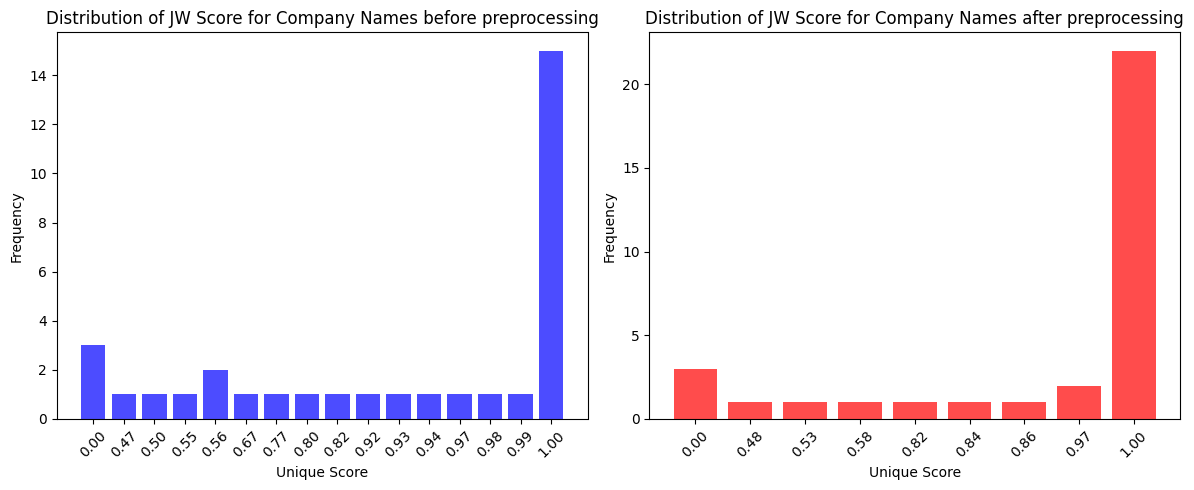

In [36]:
score_counts = company_name['company_name_jw_score'].value_counts().sort_index()
cleaned_score_counts = company_name['company_name_cleaned_jw_score'].value_counts().sort_index()

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np

# Data for first plot
a1 = score_counts.index
b1 = score_counts.values

# Data for second plot
a2 = cleaned_score_counts.index
b2 = cleaned_score_counts.values

# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First bar plot
axes[0].bar(range(len(a1)), b1, color='blue', alpha=0.7)
axes[0].set_xticks(range(len(a1)))
axes[0].set_xticklabels([f"{x:.2f}" for x in a1], rotation=45)
axes[0].set_xlabel("Unique Score")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of JW Score for Company Names before preprocessing")

# Second bar plot
axes[1].bar(range(len(a2)), b2, color='red', alpha=0.7)
axes[1].set_xticks(range(len(a2)))
axes[1].set_xticklabels([f"{x:.2f}" for x in a2], rotation=45)
axes[1].set_xlabel("Unique Score")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of JW Score for Company Names after preprocessing")

# Show the plots
plt.tight_layout()
plt.show()


In [37]:
company_name[company_name['expected_output_company_name_cleaned'] != company_name['dspy_output_company_name_cleaned']][['instance_path', 'expected_output_company_name_cleaned', 'dspy_output_company_name_cleaned', 'company_name_cleaned_jw_score']]

,instance_path,expected_output_company_name_cleaned,dspy_output_company_name_cleaned,company_name_cleaned_jw_score
2,label_035,gloco,92883354 quebec inc,0.000000
3,label_032,novago cooprative,sollio agriculture,0.581264
8,label_027,synagri seclp,synagri sec1p,0.969231
12,label_029,synagri seclp,synagri secip,0.969231
17,label_021,big blue,lep,0.000000
24,label_030,amp advanced micronutrient product inc,advanced micronutrient products inc,0.836320
26,label_001,natures aid,diamond fertilizers inc,0.525033
28,label_024,matriaux paysagers savaria lte,savaria matriaux paysagers savaria lte,0.818713
29,label_012,contrecoeur synagri,synagri lpsec,0.481332
30,label_015,gloco,92883354 quebec inc,0.000000


Seems like we can consider above 0.8 as a match.

In [38]:
correct_answer = company_name[company_name['expected_output_company_name_cleaned'] == company_name['dspy_output_company_name_cleaned']].shape[0] + (company_name[company_name['expected_output_company_name_cleaned'] != company_name['dspy_output_company_name_cleaned']][company_name['company_name_cleaned_jw_score'] > 0.8]).shape[0]
print("There are " + str(correct_answer) + " instances with the correct company name")
print("Percentage of correct answers: " + str(correct_answer/len(company_name) * 100) + "%")

There are 27 instances with the correct company name
Percentage of correct answers: 81.81818181818183%


/var/folders/f2/ftwtzjqn113d_3j7tcd850940000gn/T/ipykernel_2700/4182168043.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  correct_answer = company_name[company_name['expected_output_company_name_cleaned'] == company_name['dspy_output_company_name_cleaned']].shape[0] + (company_name[company_name['expected_output_company_name_cleaned'] != company_name['dspy_output_company_name_cleaned']][company_name['company_name_cleaned_jw_score'] > 0.8]).shape[0]


# company_address

In [39]:
print("Number of company_address None in our human analyze is", df_flatten['expected_output_company_address'].isna().sum())
exact_match_num = len(df_flatten[df_flatten['expected_output_company_address'] == df_flatten['dspy_output_company_address']])
print("There are " + str(exact_match_num) + " instances with the exact same company address")
print("Percentage of exact matches: " + str(exact_match_num/len(df_flatten[df_flatten['expected_output_company_address'].notna()]) * 100) + "%")

Number of company_address None in our human analyze is 3
There are 10 instances with the exact same company address
Percentage of exact matches: 31.25%


In [40]:
pd.set_option('display.max_colwidth', 400)

In [41]:
not_match = df_flatten[df_flatten['expected_output_company_address'] != df_flatten['dspy_output_company_address']]
not_match[['instance_path', 'expected_output_company_address', 'dspy_output_company_address']]

,instance_path,expected_output_company_address,dspy_output_company_address
0,label_004,"790 st charles street x. rr1, Breslau, Ontario N0B 1M0","790 ST. CHARLES STREET W., RR 1, BRESLAU, ONTARIO NOB 1MO"
1,label_003,"839, rue papineau, Joliette, QC J6E 2L6","839, rue Papineau, Joliette, Qc, J6E 216"
2,label_035,"26, route Maritime, Forestville, Quebec G0T 1E0","26, route Maritime, Forestville, Quebec GOT 1ED"
3,label_032,"60 rue Fenne, St-Jacques, Québec, JOK 2R0","Montréal, Québec H4N 3H7"
4,label_033,"4225, rue Saint-Joseph, Trois-Rivières (Québec) G9A 5L9","975, rue Saint-Joseph, Trois-Rivières (Québec) G9A 5L9"
6,label_002,"4075 industrielle, Contrecoeur, J0L 1C0","4075 Industrielle, Contrecoeur, JOL 1CO"
7,label_005,2400 Dallas Street Houston tx 77003 USA,"2400 Dallas Street, Houston, TX 77003 USA"
8,label_027,"4075, rue Industrielle, Contrecoeur, Qc, JOL 1CO","4075, rue Industrielle, Contrecoeur, Qc, JOL ICO"
9,label_018,"1 AVENUE PREMIER, RIVIÈRE-DU-LOUP, QC G5R 6C1","I Avenue Premier, Rivière-du-Loup, QC G5R 6CI"
11,label_016,"2457 4eme Rang Sud, St-Charles-Sur-Richelieu, Québec JOH 2G0","2457 4eme Rang Sud, St-Charles-Sur-Richelieu, Québec JOH 2GO"


In [42]:
df_flatten['expected_output_company_address_cleaned'] = df_flatten['expected_output_company_address'].apply(preprocess_string)
df_flatten['dspy_output_company_address_cleaned'] = df_flatten['dspy_output_company_address'].apply(preprocess_string)

In [43]:
exact_match_num = len(df_flatten[df_flatten['expected_output_company_name_cleaned'] == df_flatten['dspy_output_company_name_cleaned']])
print("There are " + str(exact_match_num) + " instances with the exact same company name")
print("Percentage of exact matches: " + str(exact_match_num/len(df_flatten[df_flatten['expected_output_company_name'].notna()]) * 100) + "%")

There are 22 instances with the exact same company name
Percentage of exact matches: 66.66666666666666%


In [44]:
company_address = df_flatten[df_flatten['expected_output_company_address'].notna()]
print(len(company_address))

company_address = company_address[['instance_path', 'expected_output_company_address', 'dspy_output_company_address', 'expected_output_company_address_cleaned', 'dspy_output_company_address_cleaned']]

company_address.head()

32


,instance_path,expected_output_company_address,dspy_output_company_address,expected_output_company_address_cleaned,dspy_output_company_address_cleaned
0,label_004,"790 st charles street x. rr1, Breslau, Ontario N0B 1M0","790 ST. CHARLES STREET W., RR 1, BRESLAU, ONTARIO NOB 1MO",790 st charles street x rr1 breslau ontario n0b 1m0,790 st charles street w rr 1 breslau ontario nob 1mo
1,label_003,"839, rue papineau, Joliette, QC J6E 2L6","839, rue Papineau, Joliette, Qc, J6E 216",839 rue papineau joliette qc j6e 2l6,839 rue papineau joliette qc j6e 216
2,label_035,"26, route Maritime, Forestville, Quebec G0T 1E0","26, route Maritime, Forestville, Quebec GOT 1ED",26 route maritime forestville quebec g0t 1e0,26 route maritime forestville quebec got 1ed
3,label_032,"60 rue Fenne, St-Jacques, Québec, JOK 2R0","Montréal, Québec H4N 3H7",60 rue fenne stjacques qubec jok 2r0,montral qubec h4n 3h7
4,label_033,"4225, rue Saint-Joseph, Trois-Rivières (Québec) G9A 5L9","975, rue Saint-Joseph, Trois-Rivières (Québec) G9A 5L9",4225 rue saintjoseph troisrivires qubec g9a 5l9,975 rue saintjoseph troisrivires qubec g9a 5l9


In [45]:
company_address['company_address_jw_score'] = company_address.apply(lambda x: jellyfish.jaro_winkler_similarity(x['expected_output_company_address'], x['dspy_output_company_address']), axis=1)
company_address['company_address_cleaned_jw_score'] = company_address.apply(lambda x: jellyfish.jaro_winkler_similarity(x['expected_output_company_address_cleaned'], x['dspy_output_company_address_cleaned']), axis=1)


In [46]:
print("Average Jaro-Winkler similarity score for company names: " + str(company_address['company_address_jw_score'].mean()))
print("Average Jaro-Winkler similarity score for cleaned company names: " + str(company_address['company_address_cleaned_jw_score'].mean()))

Average Jaro-Winkler similarity score for company names: 0.8995919279329778
Average Jaro-Winkler similarity score for cleaned company names: 0.9422346169616793


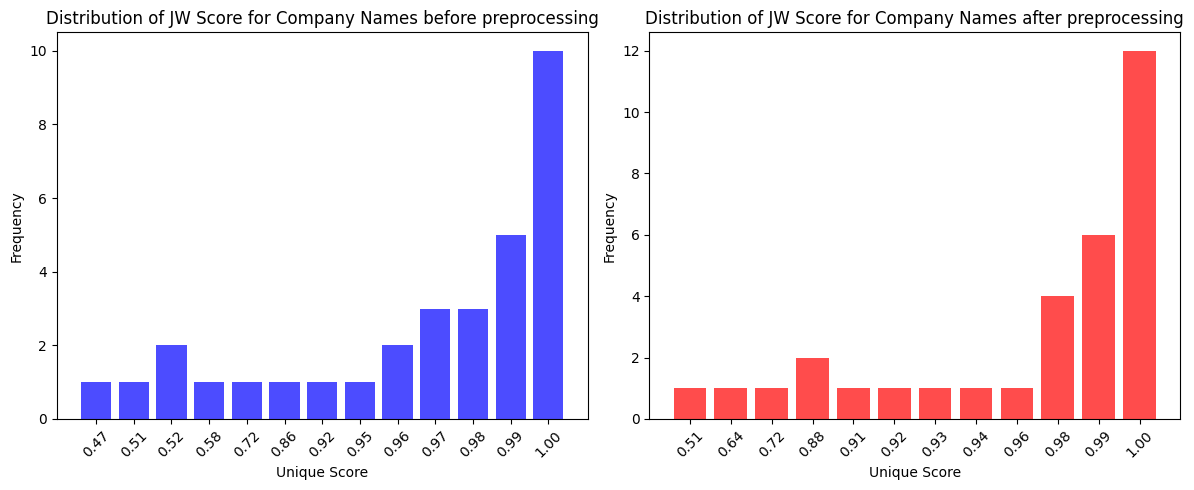

In [47]:
company_address_score_counts = round(company_address['company_address_jw_score'], 2).value_counts().sort_index()
company_address_cleaned_score_counts = round(company_address['company_address_cleaned_jw_score'], 2).value_counts().sort_index()

# company_address_score_counts = company_address['company_address_jw_score'].value_counts().sort_index()
# company_address_cleaned_score_counts = company_address['company_address_cleaned_jw_score'].value_counts().sort_index()

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np

# Data for first plot
a1 = company_address_score_counts.index
b1 = company_address_score_counts.values

# Data for second plot
a2 = company_address_cleaned_score_counts.index
b2 = company_address_cleaned_score_counts.values

# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First bar plot
axes[0].bar(range(len(a1)), b1, color='blue', alpha=0.7)
axes[0].set_xticks(range(len(a1)))
axes[0].set_xticklabels([f"{x:.2f}" for x in a1], rotation=45)
axes[0].set_xlabel("Unique Score")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of JW Score for Company Names before preprocessing")

# Second bar plot
axes[1].bar(range(len(a2)), b2, color='red', alpha=0.7)
axes[1].set_xticks(range(len(a2)))
axes[1].set_xticklabels([f"{x:.2f}" for x in a2], rotation=45)
axes[1].set_xlabel("Unique Score")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of JW Score for Company Names after preprocessing")

# Show the plots
plt.tight_layout()
plt.show()


In [48]:
correct_answer = company_address[company_address['expected_output_company_address_cleaned'] == company_address['dspy_output_company_address_cleaned']].shape[0] + (company_address[company_address['expected_output_company_address_cleaned'] != company_address['dspy_output_company_address_cleaned']][company_address['company_address_cleaned_jw_score'] > 0.8]).shape[0]
print("There are " + str(correct_answer) + " instances with the correct company address")
print("Percentage of correct answers: " + str(correct_answer/len(company_address) * 100) + "%")

There are 29 instances with the correct company address
Percentage of correct answers: 90.625%


/var/folders/f2/ftwtzjqn113d_3j7tcd850940000gn/T/ipykernel_2700/3045688863.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  correct_answer = company_address[company_address['expected_output_company_address_cleaned'] == company_address['dspy_output_company_address_cleaned']].shape[0] + (company_address[company_address['expected_output_company_address_cleaned'] != company_address['dspy_output_company_address_cleaned']][company_address['company_address_cleaned_jw_score'] > 0.8]).shape[0]


# fertilizer_name

In [49]:
print(len(df_flatten[df_flatten['expected_output_fertiliser_name'].notna()]))


34


In [50]:
exact_match_num = len(df_flatten[df_flatten['expected_output_fertiliser_name'] == df_flatten['dspy_output_fertiliser_name']])
print("There are " + str(exact_match_num) + " instances with the exact same company name")
print("Percentage of exact matches: " + str(exact_match_num/len(df_flatten[df_flatten['expected_output_fertiliser_name'].notna()]) * 100) + "%")

There are 8 instances with the exact same company name
Percentage of exact matches: 23.52941176470588%


In [51]:
df_flatten['expected_output_fertiliser_name_cleaned'] = df_flatten['expected_output_fertiliser_name'].apply(preprocess_string)
df_flatten['dspy_output_fertiliser_name_cleaned'] = df_flatten['dspy_output_fertiliser_name'].apply(preprocess_string)

In [52]:
exact_match_num = len(df_flatten[df_flatten['expected_output_fertiliser_name_cleaned'] == df_flatten['dspy_output_fertiliser_name_cleaned']])
print("There are " + str(exact_match_num) + " instances with the exact same fertilizer name")
print("Percentage of exact matches: " + str(exact_match_num/len(df_flatten[df_flatten['expected_output_fertiliser_name_cleaned'].notna()]) * 100) + "%")

There are 15 instances with the exact same fertilizer name
Percentage of exact matches: 44.11764705882353%


In [53]:
df_flatten[(df_flatten['expected_output_fertiliser_name_cleaned'] != df_flatten['dspy_output_fertiliser_name_cleaned'])][['instance_path', 'expected_output_fertiliser_name_cleaned', 'dspy_output_fertiliser_name_cleaned']]

,instance_path,expected_output_fertiliser_name_cleaned,dspy_output_fertiliser_name_cleaned
1,label_003,None,15226 vedette
2,label_035,bionik,bionik marine forest compost
3,label_032,91112 3mg plantamax,engrais minraux fertilize
4,label_033,unijardin,unjardin
8,label_027,15515 40 lent 15 mg 3s 3zn 3mn,None
9,label_018,nitrogrow,lawn soil
12,label_029,bio 432 composyn 7 ca 06mg,bio 432 composyn
13,label_011,accelerate,acceleratem
14,label_010,heattreated pellets,dry blended fertilizer
17,label_021,fish hydrolysate,bigblue


In [54]:
fertiliser_name = df_flatten[df_flatten['expected_output_fertiliser_name_cleaned'].notna()]
print(len(fertiliser_name))

fertiliser_name = fertiliser_name[['instance_path', 'expected_output_fertiliser_name', 'dspy_output_fertiliser_name', 'expected_output_fertiliser_name_cleaned', 'dspy_output_fertiliser_name_cleaned']]

fertiliser_name.head()

34


,instance_path,expected_output_fertiliser_name,dspy_output_fertiliser_name,expected_output_fertiliser_name_cleaned,dspy_output_fertiliser_name_cleaned
0,label_004,Monty's 8-16-8,MONTY'S 8-16-8,montys 8168,montys 8168
2,label_035,Bionik,Bionik Marine & Forest Compost,bionik,bionik marine forest compost
3,label_032,9-11-12 3mg PLANTAMAX,Engrais minéraux Fertilize,91112 3mg plantamax,engrais minraux fertilize
4,label_033,Unijardin,Unjardin,unijardin,unjardin
5,label_034,Overdrive,Overdrive,overdrive,overdrive


In [55]:
fertiliser_name.isna().sum()

instance_path                              0
expected_output_fertiliser_name            0
dspy_output_fertiliser_name                1
expected_output_fertiliser_name_cleaned    0
dspy_output_fertiliser_name_cleaned        1
dtype: int64

In [56]:
fertiliser_name = fertiliser_name.dropna()

In [57]:
fertiliser_name.isna().sum()

instance_path                              0
expected_output_fertiliser_name            0
dspy_output_fertiliser_name                0
expected_output_fertiliser_name_cleaned    0
dspy_output_fertiliser_name_cleaned        0
dtype: int64

In [58]:
fertiliser_name.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33 entries, 0 to 34
Data columns (total 5 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   instance_path                            33 non-null     object
 1   expected_output_fertiliser_name          33 non-null     object
 2   dspy_output_fertiliser_name              33 non-null     object
 3   expected_output_fertiliser_name_cleaned  33 non-null     object
 4   dspy_output_fertiliser_name_cleaned      33 non-null     object
dtypes: object(5)
memory usage: 1.5+ KB


In [59]:
fertiliser_name['fertiliser_name_jw_score'] = fertiliser_name.apply(lambda x: jellyfish.jaro_winkler_similarity(x['expected_output_fertiliser_name'], x['dspy_output_fertiliser_name']), axis=1)
fertiliser_name['fertiliser_name_cleaned_jw_score'] = fertiliser_name.apply(lambda x: jellyfish.jaro_winkler_similarity(x['expected_output_fertiliser_name_cleaned'], x['dspy_output_fertiliser_name_cleaned']), axis=1)

In [60]:
print("Average Jaro-Winkler similarity score for company names: " + str(fertiliser_name['fertiliser_name_jw_score'].mean()))
print("Average Jaro-Winkler similarity score for cleaned company names: " + str(fertiliser_name['fertiliser_name_cleaned_jw_score'].mean()))

Average Jaro-Winkler similarity score for company names: 0.7991217298805658
Average Jaro-Winkler similarity score for cleaned company names: 0.8750133976974983


In [61]:
fertiliser_name[fertiliser_name['expected_output_fertiliser_name_cleaned'] != fertiliser_name['dspy_output_fertiliser_name_cleaned']][['instance_path', 'expected_output_fertiliser_name_cleaned', 'dspy_output_fertiliser_name_cleaned', 'fertiliser_name_cleaned_jw_score']]

,instance_path,expected_output_fertiliser_name_cleaned,dspy_output_fertiliser_name_cleaned,fertiliser_name_cleaned_jw_score
2,label_035,bionik,bionik marine forest compost,0.842857
3,label_032,91112 3mg plantamax,engrais minraux fertilize,0.508772
4,label_033,unijardin,unjardin,0.970370
9,label_018,nitrogrow,lawn soil,0.481481
12,label_029,bio 432 composyn 7 ca 06mg,bio 432 composyn,0.923077
13,label_011,accelerate,acceleratem,0.981818
14,label_010,heattreated pellets,dry blended fertilizer,0.560287
17,label_021,fish hydrolysate,bigblue,0.470238
19,label_019,powercoat microbial inoculant,powertoal microbial inoculant,0.971921
22,label_009,75 fms extended,75 fms extended tm,0.966667


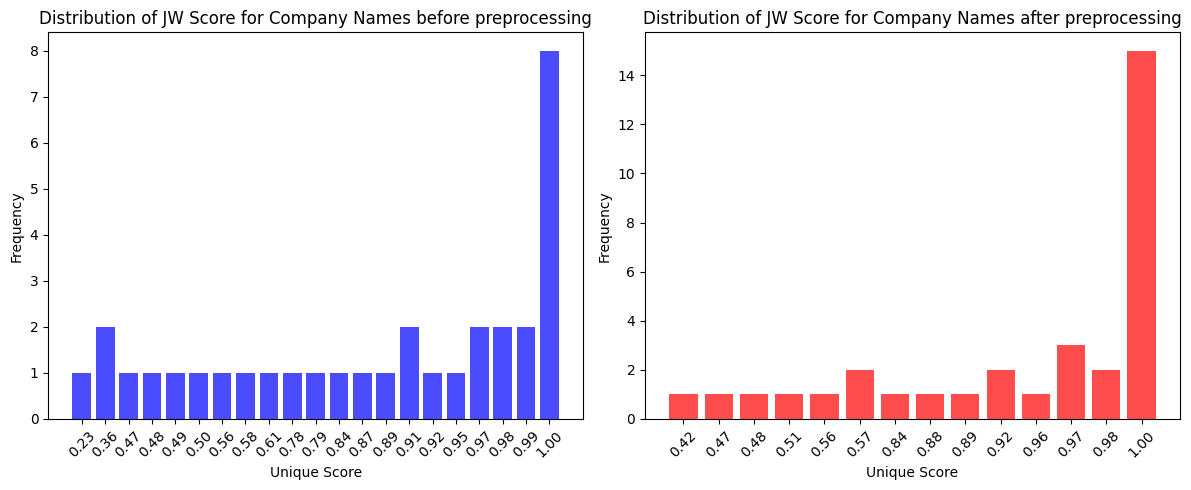

In [62]:
fertiliser_name_score_counts = round(fertiliser_name['fertiliser_name_jw_score'], 2).value_counts().sort_index()
fertiliser_name_cleaned_score_counts = round(fertiliser_name['fertiliser_name_cleaned_jw_score'], 2).value_counts().sort_index()

# company_address_score_counts = company_address['company_address_jw_score'].value_counts().sort_index()
# company_address_cleaned_score_counts = company_address['company_address_cleaned_jw_score'].value_counts().sort_index()

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np

# Data for first plot
a1 = fertiliser_name_score_counts.index
b1 = fertiliser_name_score_counts.values

# Data for second plot
a2 = fertiliser_name_cleaned_score_counts.index
b2 = fertiliser_name_cleaned_score_counts.values

# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First bar plot
axes[0].bar(range(len(a1)), b1, color='blue', alpha=0.7)
axes[0].set_xticks(range(len(a1)))
axes[0].set_xticklabels([f"{x:.2f}" for x in a1], rotation=45)
axes[0].set_xlabel("Unique Score")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of JW Score for Company Names before preprocessing")

# Second bar plot
axes[1].bar(range(len(a2)), b2, color='red', alpha=0.7)
axes[1].set_xticks(range(len(a2)))
axes[1].set_xticklabels([f"{x:.2f}" for x in a2], rotation=45)
axes[1].set_xlabel("Unique Score")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of JW Score for Company Names after preprocessing")

# Show the plots
plt.tight_layout()
plt.show()


In [63]:
correct_answer = fertiliser_name[fertiliser_name['expected_output_fertiliser_name_cleaned'] == fertiliser_name['dspy_output_fertiliser_name_cleaned']].shape[0] + (fertiliser_name[fertiliser_name['expected_output_fertiliser_name_cleaned'] != fertiliser_name['dspy_output_fertiliser_name_cleaned']][fertiliser_name['fertiliser_name_cleaned_jw_score'] > 0.8]).shape[0]
print("There are " + str(correct_answer) + " instances with the correct company name")
print("Percentage of correct answers: " + str(correct_answer/len(fertiliser_name) * 100) + "%")

There are 26 instances with the correct company name
Percentage of correct answers: 78.78787878787878%


/var/folders/f2/ftwtzjqn113d_3j7tcd850940000gn/T/ipykernel_2700/2510086634.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  correct_answer = fertiliser_name[fertiliser_name['expected_output_fertiliser_name_cleaned'] == fertiliser_name['dspy_output_fertiliser_name_cleaned']].shape[0] + (fertiliser_name[fertiliser_name['expected_output_fertiliser_name_cleaned'] != fertiliser_name['dspy_output_fertiliser_name_cleaned']][fertiliser_name['fertiliser_name_cleaned_jw_score'] > 0.8]).shape[0]


# registration_number

In [64]:
df_flatten['expected_output_registration_number'].isna().sum()

np.int64(23)

In [65]:
len(df_flatten[df_flatten['expected_output_registration_number'] == df_flatten['dspy_output_registration_number']])

11

In [66]:
print("Number of registration_number None in our human analyze is", df_flatten['expected_output_registration_number'].isna().sum())
exact_match_num = len(df_flatten[df_flatten['expected_output_registration_number'] == df_flatten['dspy_output_registration_number']])
print("There are " + str(exact_match_num) + " instances with the exact same registration number")
print("Percentage of exact matches: " + str(exact_match_num/len(df_flatten[df_flatten['expected_output_registration_number'].notna()]) * 100) + "%")

Number of registration_number None in our human analyze is 23
There are 11 instances with the exact same registration number
Percentage of exact matches: 91.66666666666666%


In [67]:
len(df_flatten[(df_flatten['expected_output_registration_number'] != df_flatten['dspy_output_registration_number']) & (df_flatten['expected_output_registration_number'].notna())])

1

In [68]:
(df_flatten[(df_flatten['expected_output_registration_number'] != df_flatten['dspy_output_registration_number']) & (df_flatten['expected_output_registration_number'].notna())])[['expected_output_registration_number', 'dspy_output_registration_number']]

,expected_output_registration_number,dspy_output_registration_number
16,2015045B,None


# instructions_en

In [69]:
print(len(df_flatten[df_flatten['expected_output_instructions_en'].notna()]))

32


In [70]:
print(len(df_flatten[df_flatten['expected_output_instructions_en'] == df_flatten['dspy_output_instructions_en']]))

3


In [256]:
df_flatten[df_flatten['expected_output_instructions_en'] == df_flatten['dspy_output_instructions_en']][['instance_path', 'expected_output_instructions_en', 'dspy_output_instructions_en']]

,instance_path,expected_output_instructions_en,dspy_output_instructions_en
8,label_027,[See your fertilization program.],[See your fertilization program.]
30,label_015,"[Prepare the soil., Sprinkle on the soil surface or in the planting hole., Mix well in the soil., Water the soil.]","[Prepare the soil., Sprinkle on the soil surface or in the planting hole., Mix well in the soil., Water the soil.]"
33,label_025,"[This product should be used on the basis of a soil and/or tissue analysis in accordance with recommendations of a qualified individual or institution, such as a certified crop advisor, agronomist, university crop extension publication or apply according to recommendations in your approved nutrient management plan., Do not mix with other fertilizers/chemicals without a compatibility test. An a...","[This product should be used on the basis of a soil and/or tissue analysis in accordance with recommendations of a qualified individual or institution, such as a certified crop advisor, agronomist, university crop extension publication or apply according to recommendations in your approved nutrient management plan., Do not mix with other fertilizers/chemicals without a compatibility test. An a..."


In [71]:
df_flatten[df_flatten['expected_output_instructions_en'] != df_flatten['dspy_output_instructions_en']][['expected_output_instructions_en', 'dspy_output_instructions_en']]

,expected_output_instructions_en,dspy_output_instructions_en
0,"[For use on all field, fruit and vegetal crops.]","[For use on all field, fruit and vegetable crops., At Planting: Apply 1-4 L/ha in furrow., Foliar Application: Apply 1-2 L/ha once or twice during growing season., Put 2/3 water in sprayer, add correct amount of Monty's plant food and other chemicals or fertilizers, if any and fill tank with balance of water., Do a compatibility check to insure proper mixing., Foliar fertilization is intended ..."
1,None,[]
2,"[Vegetable gardens and flower beds: Spread a 0.6 mm (1/4 in) layer of compost on the soil surface and quickly work into the soil., Demanding plants: Add one to three handfuls into the planting hole and work into the soil., Trees, shrubs, evergreens and hedges: Spread a 0.6 mm (1/4 in) layer of compost on the soil surface covered by the plants. Water as needed., For optimal results: Apply the c...","[Vegetable gardens and flower beds: Spread a 0.6 mm (1/4 in) layer of compost on the soil surface and quickly work into the soil., Demanding plants: Add one to three handfuls into the planting hole and work into the soil., Trees, shrubs, evergreens and hedges: Spread a 0.6 mm (1/4 in) layer of compost on the soil surface covered by the plants. Water as needed.]"
3,None,[REFER TO MATERIAL SAFETY DATA SHEET]
4,"[Spread fertilizer evenly at the base of plants and lightly hoe around to make it penetrate. It is best to apply fertilizer before a rainfall, or to water after each application. This fertilizer must be used as part of a complete fertilization program. We recommend following up maintenance with Unijardin fertilizers designed to meet the plant's specific needs.]","[Spread fertilizer evenly at the base of plants and lightly hoe around to make it penetrate., It is best to apply fertilizer before a rainfall, or to water after each application., This fertilizer must be used as part of a complete fertilization program., We recommend following up maintenance with Unijardin fertilizers designed to meet the plant's specific needs.]"
5,"[Overdrive is specially designed for use with all hydroponic growing media, including coco coir, as well as continuous liquid-feed growing systems such as aeroponics, drip irrigation and emitters, NFT, flood and drain, and deep water culture.]","[During the final weeks of bloom phase your plants need the ingredients in Overdrive® to maintain flower maturation, flower growth, and overall vigor., Many growers neglect the last weeks of bloom phase, but now you can kick it into Overdrive for a strong finish and get bigger smiles at harvest time., Overdrive is specially designed for use with all hydroponic growing media, including coco coi..."
6,[To be used only in blending fertilizer for soil application.],"[EYES: Flush thoroughly with water for at least 15 minutes. If irritation persists consult a physician., SKIN: Wash skin with plenty of water and soap., INHALATION: Remove source of contamination or move (victim) to fresh air. If breathing stops, begin artificial respiration, if necessary give oxygen., INGESTION: Drink 2 glasses of water (or milk). Seek medical advice. In all cases, summon med..."
7,[Dissolve 5 cc of Bean Promoter in 5 gallon of water. Stir until completely dissolved. Soak bean seed in the solution for 6 to 8 hours. Remove seed from solution and place into germination trays/beds. Continue to treat seed with the bean Promoter solution by spraying the seedlings uniformly once each day. Discontinue use 24 hours prior to harvest.],"[Dissolve 5 cc of Bean Promoter in 5 gallons of water., Stir until completely dissolved., Soak Bean Seeds in the solution for 6 to 8 hours., Remove seeds from the solution and place into germination trays/beds., Continue to treat the seed with the Bean Promoter solution by spraying the seedlings uniformly once each day., Discontinue use 24 hours prior to harvest.]"
9,"[Prepare the area by removing debris, weed and other vegetation., Apply in sprin

In [269]:
df_flatten['preprocessed_expected_output_instructions_en'] = df_flatten['expected_output_instructions_en'].apply(preprocess_string)
df_flatten['preprocessed_expected_output_instructions_fr'] = df_flatten['expected_output_instructions_fr'].apply(preprocess_string)

In [268]:
df_flatten['preprocessed_dspy_output_instructions_en'] = df_flatten['dspy_output_instructions_en'].apply(preprocess_string)
df_flatten['preprocessed_dspy_output_instructions_fr'] = df_flatten['dspy_output_instructions_fr'].apply(preprocess_string)

In [271]:
# df_flatten[['instance_path', 'expected_output_instructions_en', 'preprocessed_expected_output_instructions_en', 'expected_output_instructions_fr', 'preprocessed_expected_output_instructions_fr']]

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df_flatten_not_nan = df_flatten[(df_flatten['expected_output_instructions_en'].notna()) & (df_flatten['dspy_output_instructions_en'].notna())]

# Create TF-IDF vectors for the columns
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df_flatten_not_nan['preprocessed_expected_output_instructions_en'] + df_flatten_not_nan['preprocessed_dspy_output_instructions_en'])

# Compute cosine similarity
cosine_sim = []
for i, row in df_flatten_not_nan.iterrows():
    vec1 = tfidf.transform([row['preprocessed_expected_output_instructions_en']])
    vec2 = tfidf.transform([row['preprocessed_dspy_output_instructions_en']])
    similarity = cosine_similarity(vec1, vec2)[0][0]
    cosine_sim.append(similarity)

df_flatten_not_nan['cosine_similarity_tfidf'] = cosine_sim


/var/folders/f2/ftwtzjqn113d_3j7tcd850940000gn/T/ipykernel_2700/2862488881.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flatten_not_nan['cosine_similarity_tfidf'] = cosine_sim


In [75]:
# Function to compute Jaccard Similarity
def jaccard_similarity(s1, s2):
    set1 = set(s1.split())
    set2 = set(s2.split())
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union

# Apply Jaccard Similarity
df_flatten_not_nan['jaccard_similarity'] = df_flatten_not_nan.apply(lambda row: jaccard_similarity(row['preprocessed_expected_output_instructions_en'], row['preprocessed_dspy_output_instructions_en']), axis=1)

/var/folders/f2/ftwtzjqn113d_3j7tcd850940000gn/T/ipykernel_2700/2922957726.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flatten_not_nan['jaccard_similarity'] = df_flatten_not_nan.apply(lambda row: jaccard_similarity(row['preprocessed_expected_output_instructions_en'], row['preprocessed_dspy_output_instructions_en']), axis=1)


In [76]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

model = SentenceTransformer('all-MiniLM-L6-v2')

def calc_cosine_similarity(model, row):
    embeddings = model.encode([row['preprocessed_expected_output_instructions_en'], row['preprocessed_dspy_output_instructions_en']])
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])
    return similarity[0][0]

def general_cosine(model, sentence1, sentence2):
    embeddings = model.encode([sentence1, sentence2])
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])
    return similarity[0][0]

df_flatten_not_nan['cosine_similarity_sentence_transformer'] = df_flatten_not_nan.apply(lambda row: calc_cosine_similarity(model, row), axis=1)
# df_flatten_not_nan['cosine_similarity_sentence_transformer'] = df_flatten_not_nan.apply(lambda row: general_cosine(model, row['preprocessed_expected_output_instructions_en'], row['preprocessed_dspy_output_instructions_en']), axis=1)


/var/folders/f2/ftwtzjqn113d_3j7tcd850940000gn/T/ipykernel_2700/1330085503.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flatten_not_nan['cosine_similarity_sentence_transformer'] = df_flatten_not_nan.apply(lambda row: calc_cosine_similarity(model, row), axis=1)


In [77]:
# !pip install spacy
!python -m spacy download en_core_web_md

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 9.7 MB/s eta 0:00:0000:0100:01m
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [78]:
import spacy

spacy_model = spacy.load('en_core_web_md')

def calc_spacy_similarity(model, row):
    sentence1 = model(row['preprocessed_expected_output_instructions_en'])
    sentence2 = model(row['preprocessed_dspy_output_instructions_en'])

    return sentence1.similarity(sentence2)

df_flatten_not_nan['spacy_similarity'] = df_flatten_not_nan.apply(
    lambda row: calc_spacy_similarity(spacy_model, row), axis=1
)


/var/folders/f2/ftwtzjqn113d_3j7tcd850940000gn/T/ipykernel_2700/2970981498.py:9: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return sentence1.similarity(sentence2)
/var/folders/f2/ftwtzjqn113d_3j7tcd850940000gn/T/ipykernel_2700/2970981498.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flatten_not_nan['spacy_similarity'] = df_flatten_not_nan.apply(


In [79]:
pd.set_option('display.max_colwidth', 600)  # Adjust the value (100) as needed

In [80]:
df_flatten_not_nan[df_flatten_not_nan['expected_output_instructions_en'] != df_flatten_not_nan['dspy_output_instructions_en']][['expected_output_instructions_en', 'dspy_output_instructions_en', 'cosine_similarity_tfidf', 'jaccard_similarity', 'cosine_similarity_sentence_transformer', 'spacy_similarity']]

,expected_output_instructions_en,dspy_output_instructions_en,cosine_similarity_tfidf,jaccard_similarity,cosine_similarity_sentence_transformer,spacy_similarity
0,"[For use on all field, fruit and vegetal crops.]","[For use on all field, fruit and vegetable crops., At Planting: Apply 1-4 L/ha in furrow., Foliar Application: Apply 1-2 L/ha once or twice during growing season., Put 2/3 water in sprayer, add correct amount of Monty's plant food and other chemicals or fertilizers, if any and fill tank with balance of water., Do a compatibility check to insure proper mixing., Foliar fertilization is intended as a supplement to a regular fertilization program and will not, by itself, provide all the nutrients normally required by agricultural crops.]",0.285758,0.112676,0.611774,0.879265
2,"[Vegetable gardens and flower beds: Spread a 0.6 mm (1/4 in) layer of compost on the soil surface and quickly work into the soil., Demanding plants: Add one to three handfuls into the planting hole and work into the soil., Trees, shrubs, evergreens and hedges: Spread a 0.6 mm (1/4 in) layer of compost on the soil surface covered by the plants. Water as needed., For optimal results: Apply the complete Bionik Fertilization Program.]","[Vegetable gardens and flower beds: Spread a 0.6 mm (1/4 in) layer of compost on the soil surface and quickly work into the soil., Demanding plants: Add one to three handfuls into the planting hole and work into the soil., Trees, shrubs, evergreens and hedges: Spread a 0.6 mm (1/4 in) layer of compost on the soil surface covered by the plants. Water as needed.]",0.962407,0.829787,0.913434,0.994656
4,"[Spread fertilizer evenly at the base of plants and lightly hoe around to make it penetrate. It is best to apply fertilizer before a rainfall, or to water after each application. This fertilizer must be used as part of a complete fertilization program. We recommend following up maintenance with Unijardin fertilizers designed to meet the plant's specific needs.]","[Spread fertilizer evenly at the base of plants and lightly hoe around to make it penetrate., It is best to apply fertilizer before a rainfall, or to water after each application., This fertilizer must be used as part of a complete fertilization program., We recommend following up maintenance with Unijardin fertilizers designed to meet the plant's specific needs.]",1.000000,1.000000,1.000000,1.000000
5,"[Overdrive is specially designed for use with all hydroponic growing media, including coco coir, as well as continuous liquid-feed growing systems such as aeroponics, drip irrigation and emitters, NFT, flood and drain, and deep water culture.]","[During the final weeks of bloom phase your plants need the ingredients in Overdrive® to maintain flower maturation, flower growth, and overall vigor., Many growers neglect the last weeks of bloom phase, but now you can kick it into Overdrive for a strong finish and get bigger smiles at harvest time., Overdrive is specially designed for use with all hydroponic growing media, including coco coir, as well as continuous liquid-feed growing systems such as aeroponics, drip irrigation and emitters, NFT, flood and drain, and deep water culture., ATTENTION: Overdrive is completely compatible with...",0.619393,0.387500,0.803609,0.953247
6,[To be used only in blending fertilizer for soil application.],"[EYES: Flush thoroughly with water for at least 15 minutes. If irritation persists consult a physician., SKIN: Wash skin with plenty of water and soap., INHALATION: Remove source of contamination or move (victim) to fresh air. If breathing stops, begin artificial respiration, if necessary give oxygen., INGESTION: Drink 2 glasses of water (or milk). Seek medical advice. In all cases, summon medical aid IMMEDIATELY, or contact poison control center.]",0.026275,0.046154,0.028747,0.829960
7,[Dissolve 5 cc of Bean Promoter in 5 gallon of water. Stir until completely dissolved. Soak bean seed in the solution for 6 to 8 hours. Remove seed fro

In [81]:
df_flatten_not_nan.columns

Index(['instance_path', 'image_files', 'expected_output', 'dspy_output',
       'expected_output_company_name', 'expected_output_company_address',
       'expected_output_company_website',
       'expected_output_company_phone_number',
       'expected_output_manufacturer_name',
       'expected_output_manufacturer_address',
       'expected_output_manufacturer_website',
       'expected_output_manufacturer_phone_number',
       'expected_output_fertiliser_name',
       'expected_output_registration_number', 'expected_output_lot_number',
       'expected_output_weight', 'expected_output_density',
       'expected_output_volume', 'expected_output_npk',
       'expected_output_guaranteed_analysis_en',
       'expected_output_guaranteed_analysis_fr',
       'expected_output_ingredients_en', 'expected_output_ingredients_fr',
       'expected_output_cautions_en', 'expected_output_cautions_fr',
       'expected_output_instructions_en', 'expected_output_instructions_fr',
       'dspy_output_c

# cautions_en

In [82]:
print(len(df_flatten[df_flatten['expected_output_cautions_en'].notna()]))

12


In [83]:
print(len(df_flatten[df_flatten['expected_output_cautions_en'] == df_flatten['dspy_output_cautions_en']]))

2


In [84]:
df_flatten[df_flatten['expected_output_cautions_en'] != df_flatten['dspy_output_cautions_en']][['expected_output_cautions_en', 'dspy_output_cautions_en']]

,expected_output_cautions_en,dspy_output_cautions_en
0,None,[]
1,None,[]
2,None,[CONTAINS NO PEAT MOSS OR ANIMAL MANURE.]
3,None,"[Danger! Eye and skin irritant., Precautionary Measures: Avoid prolonged or repeated contact with skin. Avoid prolonged or repeated breathing of dust. Wear safety goggles., If ventilation is inadequate, wear suitable respiratory protective equipment., First Aid: If product comes in contact with eyes, flush eyes with water. If product comes in contact with skin, wash skin with water and soap. If product is ingested, do not induce vomiting. Get medical attention., This fertilizer must be used according to the recommendations of an agronomy professional.]"
4,None,"[Feeding this product to cattle, sheep, deer or other ruminants is illegal and subject to fines or other punishment under the Health of Animals Act., Not to be used on pasture land or other grazing areas for ruminants., Do not ingest., Wash hands after handling., Keep out of reach of children and pets., Preferably handle wearing gloves., Avoid applying during times of drought.]"
5,None,[]
6,[This fertilizer contains Boron and should be used only as recommended.],"[CAUTION this fertilizer contains Boron and should be used only as recommended, It may prove harmful when misused. Applications of this product should be based on the results of soil and/or tissue analysis., TO BE USED ONLY IN BLENDING FERTILIZER FOR SOIL APPLICATIONS, WARNING POISON May be harmful if swallowed, PRECAUTIONS: Do NOT take Internally. Avoid eye or skin contact. Do not breathe dust. Store in cool dry, well ventilated area. Keep out of reach of children. When handling, wear NIOSH-approved respirator, chemical resistant gloves, safety goggles, rubber boots, and appropriate cloth..."
7,None,"[Keep out of the reach of children., Avoid contact with eyes and skin., Do not swallow., If in eyes, flush with plenty of water., If on skin, wash with plenty of soap and water., If swallowed, seek medical treatment immediately.]"
9,None,"[Store in original bag in a dry area., Recycle empty bag.]"
10,None,"[First-aid measures, Eye contact: In case of contact with substance, immediately flush eyes with running water at least 20 minutes. Do not rub your eyes., Skin contact: In case of contact with substance, immediately flush skin with running water at least 20 minutes. Get immediate medical advice/attention., Inhalation: Specific medical treatment is urgent.]"


In [85]:
df_flatten['preprocessed_expected_output_cautions_en'] = df_flatten['expected_output_cautions_en'].apply(preprocess_string)
df_flatten['preprocessed_dspy_output_cautions_en'] = df_flatten['dspy_output_cautions_en'].apply(preprocess_string)

In [86]:
df_flatten_caution_not_nan = df_flatten[(df_flatten['expected_output_cautions_en'].notna()) & (df_flatten['dspy_output_cautions_en'].notna())]

caution_tfidf = TfidfVectorizer()
caution_tfidf_matrix = caution_tfidf.fit_transform(df_flatten_caution_not_nan['preprocessed_expected_output_cautions_en'] + df_flatten_caution_not_nan['preprocessed_dspy_output_cautions_en'])

caution_cosine_sim = []
for i, row in df_flatten_caution_not_nan.iterrows():
    vec1 = caution_tfidf.transform([row['preprocessed_expected_output_cautions_en']])
    vec2 = caution_tfidf.transform([row['preprocessed_dspy_output_cautions_en']])
    similarity = cosine_similarity(vec1, vec2)[0][0]
    caution_cosine_sim.append(similarity)

df_flatten_caution_not_nan['caution_cosine_similarity_tfidf'] = caution_cosine_sim

/var/folders/f2/ftwtzjqn113d_3j7tcd850940000gn/T/ipykernel_2700/410080169.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flatten_caution_not_nan['caution_cosine_similarity_tfidf'] = caution_cosine_sim


In [87]:
df_flatten_caution_not_nan['caution_jaccard_similarity'] = df_flatten_caution_not_nan.apply(lambda row: jaccard_similarity(row['preprocessed_expected_output_cautions_en'], row['preprocessed_dspy_output_cautions_en']), axis=1)

/var/folders/f2/ftwtzjqn113d_3j7tcd850940000gn/T/ipykernel_2700/3385662272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flatten_caution_not_nan['caution_jaccard_similarity'] = df_flatten_caution_not_nan.apply(lambda row: jaccard_similarity(row['preprocessed_expected_output_cautions_en'], row['preprocessed_dspy_output_cautions_en']), axis=1)


In [88]:
# df_flatten_not_nan['caution_cosine_similarity_sentence_transformer'] = df_flatten_not_nan.apply(lambda row: calc_cosine_similarity(model, row), axis=1)
df_flatten_caution_not_nan['cosine_similarity_sentence_transformer'] = df_flatten_caution_not_nan.apply(lambda row: general_cosine(model, row['preprocessed_expected_output_cautions_en'], row['preprocessed_dspy_output_cautions_en']), axis=1)


/var/folders/f2/ftwtzjqn113d_3j7tcd850940000gn/T/ipykernel_2700/254649752.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flatten_caution_not_nan['cosine_similarity_sentence_transformer'] = df_flatten_caution_not_nan.apply(lambda row: general_cosine(model, row['preprocessed_expected_output_cautions_en'], row['preprocessed_dspy_output_cautions_en']), axis=1)


In [89]:
spacy_model = spacy.load('en_core_web_md')

# Define the similarity calculation function
def caution_calc_spacy_similarity(model, row):
    sentence1 = model(row['preprocessed_expected_output_cautions_en'])
    sentence2 = model(row['preprocessed_dspy_output_cautions_en'])

    return sentence1.similarity(sentence2)

# Apply the similarity calculation to the DataFrame
df_flatten_caution_not_nan['spacy_similarity'] = df_flatten_not_nan.apply(
    lambda row: calc_spacy_similarity(spacy_model, row), axis=1
)

/var/folders/f2/ftwtzjqn113d_3j7tcd850940000gn/T/ipykernel_2700/2970981498.py:9: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return sentence1.similarity(sentence2)
/var/folders/f2/ftwtzjqn113d_3j7tcd850940000gn/T/ipykernel_2700/3867254743.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flatten_caution_not_nan['spacy_similarity'] = df_flatten_not_nan.apply(


In [90]:
df_flatten_caution_not_nan[['expected_output_cautions_en', 'dspy_output_cautions_en', 'caution_cosine_similarity_tfidf', 'caution_jaccard_similarity', 'cosine_similarity_sentence_transformer', 'spacy_similarity']]

,expected_output_cautions_en,dspy_output_cautions_en,caution_cosine_similarity_tfidf,caution_jaccard_similarity,cosine_similarity_sentence_transformer,spacy_similarity
6,[This fertilizer contains Boron and should be used only as recommended.],"[CAUTION this fertilizer contains Boron and should be used only as recommended, It may prove harmful when misused. Applications of this product should be based on the results of soil and/or tissue analysis., TO BE USED ONLY IN BLENDING FERTILIZER FOR SOIL APPLICATIONS, WARNING POISON May be harmful if swallowed, PRECAUTIONS: Do NOT take Internally. Avoid eye or skin contact. Do not breathe dust. Store in cool dry, well ventilated area. Keep out of reach of children. When handling, wear NIOSH-approved respirator, chemical resistant gloves, safety goggles, rubber boots, and appropriate cloth...",0.290986,0.127907,0.706973,0.829960
8,"[This fertilizer contains Boron (B), Zinc (Zn), Copper (Cu), Manganese (Mn) and should be used only as recommended. May be harmful if misused.]","[This fertilizer contains Boron (B), Zinc (Zn), Copper (Cu), Manganese (Mn) and should be used only as recommended. May be harmful if misused.]",1.000000,1.000000,1.000000,1.000000
11,[WARNING this fertilizer contains boron and should be used only as recommended. It may prove harmful when misused.],"[WARNING this fertilizer contains boron and should be used only as recommended, it may prove harmful when misused., KEEP OUT OF REACH OF CHILDREN., Keep in tightly sealed closed container. Do not contaminate water, food or feed by storage or disposal., Mixers, loaders, applicators and other handlers must wear: long sleeved shirt and long pants, shoes plus socks, chemical-resistant gloves and protective eyewear. Wash thoroughly after handling., If on skin: wash with plenty of water. Take off contaminated clothing and wash it before reuse., If in eyes: rinse continuously with water for sever...",0.256421,0.204545,0.827226,0.993075
13,"[CAUTION: product contains fish, shellfish and soy. Adverse reactions may occur in sensitive persons. If skin contact occurs, wash with soap and water. Wear dust mask and protective gloves. If allergic reaction occurs, seek medical attention., Caution: This fertilizer contains boron, copper, manganese, molybdenum and zinc and should be used only as recommended. It may prove harmful when misused.]","[CAUTION: product contains fish, shellfish and soy. Adverse reactions may occur in sensitive persons. If skin contact occurs, wash with soap and water. Wear dust mask and protective gloves. If allergic reaction occurs, seek medical attention., Caution: This fertilizer contains boron, copper, manganese, molybdenum and zinc and should be used only as recommended. It may prove harmful when misused., Hazard Statements: Suspected of damaging fertility or the unborn child. May cause damage to organs through prolonged or repeated exposure. Keep out of reach of children. Wear standard work clothes...",0.696870,0.480769,0.903117,0.999446
16,[This fertilizer contains zinc and sulfur and should be used only as recommended],[CAUTION this fertilizer contains Zinc and Sulphur and should be used only as recommended. It may prove harmful when misused. Applications of this product should be based on the results of soil and/or tissue analysis.],0.421864,0.354839,0.872604,0.982499
18,[This fertilizer contains boron and should be used only as recommended. It may prove harmful when misused.],"[May damage fertility or the unborn child, Keep out of reach of children, Strictly not for use in food products and medicines, Avoid contamination of food, feed, domestic or irrigation water supplies, lakes, streams and ponds, This fertilizer contains boron and should be used only as recommended. It may prove harmful when misused, The use of this fertilizing material on any crop(s) other than those recommended may result in serious injury to the crop(s), This fertilizer should be used only as recommended. It may prove harmful when 

# weight

In [91]:
df_flatten['expected_output_weight'].isna().sum()

np.int64(0)

In [92]:
df_flatten['dspy_output_weight'].isna().sum()

np.int64(0)

In [93]:
len(df_flatten[df_flatten['expected_output_weight'] == df_flatten['dspy_output_weight']])

6

In [94]:
len(df_flatten[df_flatten['expected_output_weight'] != df_flatten['dspy_output_weight']][['instance_path', 'expected_output_weight', 'dspy_output_weight']])

29

In [95]:
def clean_weights(weights):
    cleaned_weights = []
    for weight in weights:
        if weight['value'] is not None:
            cleaned_weights.append({'value': weight['value'], 'unit': weight['unit'].lower().replace('s', '')})
    return cleaned_weights

df_flatten['expected_output_weight_cleaned'] = df_flatten['expected_output_weight'].apply(clean_weights)
df_flatten['dspy_output_weight_cleaned'] = df_flatten['dspy_output_weight'].apply(clean_weights)

In [96]:
df_flatten[(df_flatten['expected_output_weight'] != df_flatten['dspy_output_weight']) & (df_flatten['expected_output_weight_cleaned'] == df_flatten['dspy_output_weight_cleaned'])][['instance_path', 'expected_output_weight', 'expected_output_weight_cleaned', 'dspy_output_weight_cleaned', 'dspy_output_weight']]

,instance_path,expected_output_weight,expected_output_weight_cleaned,dspy_output_weight_cleaned,dspy_output_weight
3,label_032,"[{'value': 25, 'unit': 'Kgs'}, {'value': None, 'unit': 'lb'}]","[{'value': 25, 'unit': 'kg'}]","[{'value': 25.0, 'unit': 'kg'}]","[{'value': 25.0, 'unit': 'Kgs'}]"
4,label_033,"[{'value': 2, 'unit': 'kg'}, {'value': None, 'unit': 'lb'}]","[{'value': 2, 'unit': 'kg'}]","[{'value': 2.0, 'unit': 'kg'}]","[{'value': 2.0, 'unit': 'kg'}]"
8,label_027,"[{'value': 25, 'unit': 'kg'}, {'value': None, 'unit': 'lb'}]","[{'value': 25, 'unit': 'kg'}]","[{'value': 25.0, 'unit': 'kg'}]","[{'value': 25.0, 'unit': 'Kg'}]"
10,label_020,"[{'value': None, 'unit': 'kg'}, {'value': None, 'unit': 'lb'}]",[],[],[]
14,label_010,"[{'value': None, 'unit': 'kg'}, {'value': 25, 'unit': 'lb'}]","[{'value': 25, 'unit': 'lb'}]","[{'value': 25.0, 'unit': 'lb'}]","[{'value': 25.0, 'unit': 'Lbs'}]"
20,label_007,"[{'value': 13.6, 'unit': 'kg'}, {'value': 30, 'unit': 'lb'}]","[{'value': 13.6, 'unit': 'kg'}, {'value': 30, 'unit': 'lb'}]","[{'value': 13.6, 'unit': 'kg'}, {'value': 30.0, 'unit': 'lb'}]","[{'value': 13.6, 'unit': 'kg'}, {'value': 30.0, 'unit': 'lbs'}]"
21,label_031,"[{'value': 327, 'unit': 'g'}, {'value': None, 'unit': 'lb'}]","[{'value': 327, 'unit': 'g'}]","[{'value': 327.0, 'unit': 'g'}]","[{'value': 327.0, 'unit': 'g'}]"
22,label_009,"[{'value': 25, 'unit': 'kg'}, {'value': 55, 'unit': 'lb'}]","[{'value': 25, 'unit': 'kg'}, {'value': 55, 'unit': 'lb'}]","[{'value': 25.0, 'unit': 'kg'}, {'value': 55.0, 'unit': 'lb'}]","[{'value': 25.0, 'unit': 'KG'}, {'value': 55.0, 'unit': 'lb'}]"
23,label_008,"[{'value': None, 'unit': 'kg'}, {'value': None, 'unit': 'lb'}]",[],[],[]
24,label_030,"[{'value': 907, 'unit': 'kg'}, {'value': 2000, 'unit': 'lb'}]","[{'value': 907, 'unit': 'kg'}, {'value': 2000, 'unit': 'lb'}]","[{'value': 907.0, 'unit': 'kg'}, {'value': 2000.0, 'unit': 'lb'}]","[{'value': 907.0, 'unit': 'kg'}, {'value': 2000.0, 'unit': 'lbs'}]"


In [97]:
print("Equal", len(df_flatten[df_flatten['expected_output_weight_cleaned'] == df_flatten['dspy_output_weight_cleaned']]))
print("Not Equal", len(df_flatten[df_flatten['expected_output_weight_cleaned'] != df_flatten['dspy_output_weight_cleaned']]))

Equal 22
Not Equal 13


In [98]:
print("Performance before preprocess:", len(df_flatten[df_flatten['expected_output_weight'] == df_flatten['dspy_output_weight']])/len(df_flatten[df_flatten['expected_output_weight'].notna()]) * 100)
print("Performance after preprocess:", len(df_flatten[df_flatten['expected_output_weight_cleaned'] == df_flatten['dspy_output_weight_cleaned']])/len(df_flatten[df_flatten['expected_output_weight'].notna()]) * 100)

Performance before preprocess: 17.142857142857142
Performance after preprocess: 62.857142857142854


Reducing number of differences from 29 to 13

# density

In [224]:
df_flatten[['instance_path', 'expected_output_weight', 'dspy_output_weight']]

,instance_path,expected_output_weight,dspy_output_weight
0,label_004,"[{'value': 13.4, 'unit': 'kg'}]","[{'value': 13.4, 'unit': 'kg'}, {'value': 10.0, 'unit': 'L'}]"
1,label_003,"[{'value': 1000, 'unit': 'kg'}]","[{'value': 1000.0, 'unit': 'kg'}]"
2,label_035,"[{'value': 14, 'unit': 'kg'}, {'value': 30.8, 'unit': 'lb'}]","[{'value': 22.0, 'unit': 'L'}, {'value': 14.0, 'unit': 'kg'}, {'value': 30.8, 'unit': 'lb'}]"
3,label_032,"[{'value': 25, 'unit': 'Kgs'}, {'value': None, 'unit': 'lb'}]","[{'value': 25.0, 'unit': 'Kgs'}]"
4,label_033,"[{'value': 2, 'unit': 'kg'}, {'value': None, 'unit': 'lb'}]","[{'value': 2.0, 'unit': 'kg'}]"
5,label_034,"[{'value': 1.1, 'unit': 'kg'}, {'value': 2.4, 'unit': 'lbs'}]","[{'value': 1.1, 'unit': 'kg'}, {'value': 2.4, 'unit': 'lbs'}]"
6,label_002,"[{'value': 1000, 'unit': 'kg'}]","[{'value': 1000.0, 'unit': 'kg'}]"
7,label_005,"[{'value': 4.08, 'unit': 'kg'}, {'value': 9, 'unit': 'lb'}]","[{'value': 1.0, 'unit': 'Gallon'}, {'value': 3.8, 'unit': 'L'}, {'value': 9.0, 'unit': 'lbs'}, {'value': 4.08, 'unit': 'Kg'}]"
8,label_027,"[{'value': 25, 'unit': 'kg'}, {'value': None, 'unit': 'lb'}]","[{'value': 25.0, 'unit': 'Kg'}]"
9,label_018,"[{'value': None, 'unit': 'kg'}, {'value': None, 'unit': 'lb'}]","[{'value': 28.3, 'unit': 'L'}]"


In [101]:
df_flatten2['expected_output_density.value'].isna().sum()

np.int64(28)

In [114]:
df_flatten2['expected_output_density.unit'].isna().sum()

np.int64(28)

In [120]:
df_flatten2['dspy_output_density.value'].isna().sum()

np.int64(30)

In [107]:
len(df_flatten2[df_flatten2['expected_output_density.value'].isna() & df_flatten2['dspy_output_density.unit'].isna()])

28

In [210]:
df_flatten['expected_output_density'][:5]

0         {'value': None, 'unit': None}
1     {'value': 97.46, 'unit': 'kg/hl'}
2         {'value': None, 'unit': None}
3    {'value': 107.39, 'unit': 'KG/HL'}
4         {'value': None, 'unit': None}
Name: expected_output_density, dtype: object

In [119]:
df_flatten2[(df_flatten2['expected_output_density.value'].notna())][['instance_path', 'expected_output_density.value', 'expected_output_density.unit', 'dspy_output_density.value', 'dspy_output_density.unit']]

,instance_path,expected_output_density.value,expected_output_density.unit,dspy_output_density.value,dspy_output_density.unit
1,label_003,97.46,kg/hl,97.46,kg/hl
3,label_032,107.39,KG/HL,107.39,KG/HL
8,label_027,1036.00,kg/m3 ou 64.74 lbs/pi3,1036.00,kg/m3
12,label_029,752.00,kg/m3,NaN,NaN
13,label_011,1.12,kg/L,1.12,kg/L
29,label_012,724.00,kg/m3,724.00,kg/m3
34,label_022,36.00,lb./ft3,NaN,NaN


In [111]:
df_flatten2['expected_output_density.unit_lowered'] = df_flatten2['expected_output_density.unit'].str.lower()
df_flatten2['dspy_output_density.unit_lowered'] = df_flatten2['dspy_output_density.unit'].str.lower()

In [113]:
df_flatten2[(df_flatten2['expected_output_density.value'].notna()) & (df_flatten2['expected_output_density.unit_lowered'].notna())][['instance_path', 'expected_output_density.value', 'dspy_output_density.value', 'expected_output_density.unit', 'expected_output_density.unit_lowered', 'dspy_output_density.unit']]

,instance_path,expected_output_density.value,dspy_output_density.value,expected_output_density.unit,expected_output_density.unit_lowered,dspy_output_density.unit
1,label_003,97.46,97.46,kg/hl,kg/hl,kg/hl
3,label_032,107.39,107.39,KG/HL,kg/hl,KG/HL
8,label_027,1036.00,1036.00,kg/m3 ou 64.74 lbs/pi3,kg/m3 ou 64.74 lbs/pi3,kg/m3
12,label_029,752.00,NaN,kg/m3,kg/m3,NaN
13,label_011,1.12,1.12,kg/L,kg/l,kg/L
29,label_012,724.00,724.00,kg/m3,kg/m3,kg/m3
34,label_022,36.00,NaN,lb./ft3,lb./ft3,NaN


In [115]:
df_flatten2[(df_flatten2['expected_output_density.value'] == df_flatten2['dspy_output_density.value']) & (df_flatten2['expected_output_density.unit'] == df_flatten2['dspy_output_density.unit'])][['expected_output_density.value', 'dspy_output_density.value', 'expected_output_density.unit', 'dspy_output_density.unit']]

,expected_output_density.value,dspy_output_density.value,expected_output_density.unit,dspy_output_density.unit
1,97.46,97.46,kg/hl,kg/hl
3,107.39,107.39,KG/HL,KG/HL
13,1.12,1.12,kg/L,kg/L
29,724.00,724.00,kg/m3,kg/m3


In [116]:
df_flatten2[(df_flatten2['expected_output_density.value'] == df_flatten2['dspy_output_density.value']) & (df_flatten2['expected_output_density.unit'] == df_flatten2['dspy_output_density.unit'])][['expected_output_density.value', 'dspy_output_density.value', 'expected_output_density.unit', 'dspy_output_density.unit', 'expected_output_density.unit_lowered', 'dspy_output_density.unit_lowered']]

,expected_output_density.value,dspy_output_density.value,expected_output_density.unit,dspy_output_density.unit,expected_output_density.unit_lowered,dspy_output_density.unit_lowered
1,97.46,97.46,kg/hl,kg/hl,kg/hl,kg/hl
3,107.39,107.39,KG/HL,KG/HL,kg/hl,kg/hl
13,1.12,1.12,kg/L,kg/L,kg/l,kg/l
29,724.00,724.00,kg/m3,kg/m3,kg/m3,kg/m3


In [118]:
print("Performance before preprocess:", len(
    df_flatten2[(df_flatten2['expected_output_density.value'] == df_flatten2['dspy_output_density.value']) & (df_flatten2['expected_output_density.unit'] == df_flatten2['dspy_output_density.unit'])]) / len(df_flatten2[(df_flatten2['expected_output_density.value'].notna()) & (df_flatten2['expected_output_density.unit'].notna())]) * 100)

print("Performance after preprocess:", len(
    df_flatten2[(df_flatten2['expected_output_density.value'] == df_flatten2['dspy_output_density.value']) & (df_flatten2['expected_output_density.unit_lowered'] == df_flatten2['dspy_output_density.unit_lowered'])]) / len(df_flatten2[(df_flatten2['expected_output_density.value'].notna()) & (df_flatten2['expected_output_density.unit'].notna())]) * 100)

Performance before preprocess: 57.14285714285714
Performance after preprocess: 57.14285714285714


For density, the major problem was with the Nan answers from DSPy. As you can see, there is no room for improvement with preprocessing the outputs.

# volume

In [202]:
df_flatten2['expected_output_volume.value'].isna().sum()

np.int64(23)

In [203]:
df_flatten2['expected_output_volume.unit'].isna().sum()

np.int64(23)

In [206]:
len(df_flatten2[df_flatten2['expected_output_volume.value'].isna() & df_flatten2['expected_output_volume.unit'].isna()])

23

In [208]:
df_flatten2['dspy_output_volume.value'].isna().sum()

np.int64(26)

In [209]:
len(df_flatten2[df_flatten2['dspy_output_volume.value'].isna() & df_flatten2['dspy_output_volume.unit'].isna()])

26

In [219]:
len(df_flatten2[df_flatten2['expected_output_volume.value'].isna() & df_flatten2['expected_output_volume.unit'].isna() & df_flatten2['dspy_output_volume.value'].isna() & df_flatten2['dspy_output_volume.unit'].isna()])

23

In [213]:
df_flatten2[(df_flatten2['expected_output_volume.value'].notna())][['instance_path', 'expected_output_volume.value', 'expected_output_volume.unit', 'dspy_output_volume.value', 'dspy_output_volume.unit']]

,instance_path,expected_output_volume.value,expected_output_volume.unit,dspy_output_volume.value,dspy_output_volume.unit
2,label_035,22.0,L,NaN,NaN
5,label_034,1.0,L,1.0,L
9,label_018,28.3,L,NaN,NaN
15,label_017,28.3,L,NaN,NaN
17,label_021,250.0,ml,250.0,ml
19,label_019,500.0,L,500.0,L
20,label_007,10.0,L,10.0,L
21,label_031,250.0,ml,250.0,ml
25,label_006,10.0,L,10.0,L
26,label_001,10.0,liter,10.0,Liter


In [215]:
df_flatten2['expected_output_volume.unit_lowered'] = df_flatten2['expected_output_volume.unit'].str.lower()
df_flatten2['dspy_output_volume.unit_lowered'] = df_flatten2['dspy_output_volume.unit'].str.lower()

In [216]:
df_flatten2[(df_flatten2['expected_output_volume.value'] == df_flatten2['dspy_output_volume.value']) & (df_flatten2['expected_output_volume.unit'] == df_flatten2['dspy_output_volume.unit'])][['expected_output_volume.value', 'dspy_output_volume.value', 'expected_output_volume.unit', 'dspy_output_volume.unit']]

,expected_output_volume.value,dspy_output_volume.value,expected_output_volume.unit,dspy_output_volume.unit
5,1.0,1.0,L,L
17,250.0,250.0,ml,ml
19,500.0,500.0,L,L
20,10.0,10.0,L,L
21,250.0,250.0,ml,ml
25,10.0,10.0,L,L
27,16.0,16.0,oz,oz
32,2.1,2.1,Liters,Liters


In [218]:
df_flatten2[(df_flatten2['expected_output_volume.value'] == df_flatten2['dspy_output_volume.value']) & (df_flatten2['expected_output_volume.unit_lowered'] == df_flatten2['dspy_output_volume.unit_lowered'])][['expected_output_volume.value', 'dspy_output_volume.value', 'expected_output_volume.unit', 'dspy_output_volume.unit']]

,expected_output_volume.value,dspy_output_volume.value,expected_output_volume.unit,dspy_output_volume.unit
5,1.0,1.0,L,L
17,250.0,250.0,ml,ml
19,500.0,500.0,L,L
20,10.0,10.0,L,L
21,250.0,250.0,ml,ml
25,10.0,10.0,L,L
26,10.0,10.0,liter,Liter
27,16.0,16.0,oz,oz
32,2.1,2.1,Liters,Liters


In [220]:
print("Performance before preprocess:", len(
    df_flatten2[(df_flatten2['expected_output_volume.value'] == df_flatten2['dspy_output_volume.value']) & (df_flatten2['expected_output_volume.unit'] == df_flatten2['dspy_output_volume.unit'])]) / len(df_flatten2[(df_flatten2['expected_output_volume.value'].notna()) & (df_flatten2['expected_output_volume.unit'].notna())]) * 100)

print("Performance after preprocess:", len(
    df_flatten2[(df_flatten2['expected_output_volume.value'] == df_flatten2['dspy_output_volume.value']) & (df_flatten2['expected_output_volume.unit_lowered'] == df_flatten2['dspy_output_volume.unit_lowered'])]) / len(df_flatten2[(df_flatten2['expected_output_volume.value'].notna()) & (df_flatten2['expected_output_volume.unit'].notna())]) * 100)

Performance before preprocess: 66.66666666666666
Performance after preprocess: 75.0


# npk

In [121]:
df_flatten['expected_output_npk'].isna().sum()

np.int64(15)

In [122]:
df_flatten['dspy_output_npk'].isna().sum()

np.int64(16)

In [123]:
len(df_flatten[df_flatten['expected_output_npk'] == df_flatten['dspy_output_npk']][['expected_output_npk', 'dspy_output_npk']])

12

In [124]:
df_flatten[(df_flatten['expected_output_npk'] != df_flatten['dspy_output_npk']) & (df_flatten['expected_output_npk'].notna())][['instance_path', 'expected_output_npk', 'dspy_output_npk']]

,instance_path,expected_output_npk,dspy_output_npk
7,label_005,0.3-3,0-3-3
8,label_027,2015-05-15,15-5-15
9,label_018,2009-06-06,None
11,label_016,16-32-6,None
13,label_011,2000-01-01,0-1-1
14,label_010,4 3 2,4-2-2
16,label_028,none,None
31,label_014,4 6 8,4-6-8


In [128]:
df_flatten.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 64 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   instance_path                                 35 non-null     object
 1   image_files                                   35 non-null     object
 2   expected_output                               35 non-null     object
 3   dspy_output                                   35 non-null     object
 4   expected_output_company_name                  33 non-null     object
 5   expected_output_company_address               32 non-null     object
 6   expected_output_company_website               16 non-null     object
 7   expected_output_company_phone_number          13 non-null     object
 8   expected_output_manufacturer_name             6 non-null      object
 9   expected_output_manufacturer_address          6 non-null      object
 10  expe

# lot number

In [129]:
df_flatten['expected_output_lot_number'].isna().sum()

np.int64(28)

In [83]:
len(df_flatten[df_flatten['expected_output_lot_number'] == df_flatten['dspy_output_lot_number']])

6

In [87]:
df_flatten[(df_flatten['expected_output_lot_number'].notna()) & (df_flatten['expected_output_lot_number'] == df_flatten['dspy_output_lot_number'])][['expected_output_lot_number', 'dspy_output_lot_number']]

,expected_output_lot_number,dspy_output_lot_number
0,3,3
1,18538,18538
11,1012-22-B15G,1012-22-B15G
16,31923352,31923352
18,6151,6151
24,34913501,34913501


In [88]:
df_flatten[(df_flatten['expected_output_lot_number'].notna()) & (df_flatten['expected_output_lot_number'] != df_flatten['dspy_output_lot_number'])][['instance_path', 'expected_output_lot_number', 'dspy_output_lot_number']]

,instance_path,expected_output_lot_number,dspy_output_lot_number
6,label_002,2015-12-04 00:00,2015-12-04


# Guaranteed Analysis

In [130]:
df_flatten['expected_output_guaranteed_analysis_en'].isna().sum()

np.int64(0)

In [131]:
df_flatten['expected_output_guaranteed_analysis_fr'].isna().sum()

np.int64(0)

In [132]:
df_flatten['dspy_output_guaranteed_analysis_en'].isna().sum()

np.int64(4)

In [133]:
df_flatten['dspy_output_guaranteed_analysis_fr'].isna().sum()

np.int64(11)

In [140]:
def find_none(row, en_title_none, fr_title_none, en_nutrients_none, fr_nutrients_none):
    if row['expected_output_guaranteed_analysis_en']['title'] is None:
        en_title_none.append(row['instance_path'])
    if row['expected_output_guaranteed_analysis_fr']['title'] is None:
        fr_title_none.append(row['instance_path'])
    if row['expected_output_guaranteed_analysis_en']['nutrients'] is None or len(row['expected_output_guaranteed_analysis_en']['nutrients']) == 0:
        en_nutrients_none.append(row['instance_path'])
    if row['expected_output_guaranteed_analysis_fr']['nutrients'] is None or len(row['expected_output_guaranteed_analysis_fr']['nutrients']) == 0:
        fr_nutrients_none.append(row['instance_path'])

en_title_none = []
fr_title_none = []
en_nutrients_none = []
fr_nutrients_none = []

for i, row in df_flatten.iterrows():
    find_none(row, en_title_none, fr_title_none, en_nutrients_none, fr_nutrients_none)

In [141]:
print("Number of instances with None title in English:", len(en_title_none))
print(en_title_none)
print("Number of instances with None nutrients in English:", len(en_nutrients_none))
print(en_nutrients_none)
print("Number of instances with None title in French:", len(fr_title_none))
print(fr_title_none)
print("Number of instances with None nutrients in French:", len(fr_nutrients_none))
print(fr_nutrients_none)

Number of instances with None title in English: 3
['label_032', 'label_031', 'label_024']
Number of instances with None nutrients in English: 3
['label_032', 'label_031', 'label_024']
Number of instances with None title in French: 6
['label_034', 'label_026', 'label_031', 'label_008', 'label_023', 'label_022']
Number of instances with None nutrients in French: 6
['label_034', 'label_026', 'label_031', 'label_008', 'label_023', 'label_022']


In [152]:
df_flatten[df_flatten['dspy_output_guaranteed_analysis_en'].isna()][['instance_path', 'expected_output_guaranteed_analysis_en', 'dspy_output_guaranteed_analysis_en']]

,instance_path,expected_output_guaranteed_analysis_en,dspy_output_guaranteed_analysis_en
1,label_003,"{'title': 'Guaranteed Analysis', 'nutrients': [{'nutrient': 'Total Nitrogen (N)', 'value': 15, 'unit': '%'}, {'nutrient': 'Available Phosphate (P2O5)', 'value': 22, 'unit': '%'}, {'nutrient': 'Soluble Potash (K2O)', 'value': 6, 'unit': '%'}, {'nutrient': 'Magnesium (Mg)', 'value': 1.21, 'unit': '%'}, {'nutrient': 'Boron (B)', 'value': 0.12, 'unit': '%'}, {'nutrient': 'Sulfur (S)', 'value': 6.36, 'unit': '%'}, {'nutrient': 'Calcium (Ca)', 'value': 1.24, 'unit': '%'}, {'nutrient': 'Zinc (Zn)', 'value': 0.55, 'unit': '%'}, {'nutrient': 'Matter Content', 'value': 0.5, 'unit': '%'}]}",None
3,label_032,"{'title': None, 'nutrients': None}",None
21,label_031,"{'title': None, 'nutrients': []}",None
28,label_024,"{'title': None, 'nutrients': None}",None


In [153]:
df_flatten[df_flatten['dspy_output_guaranteed_analysis_fr'].isna()][['instance_path', 'expected_output_guaranteed_analysis_fr', 'dspy_output_guaranteed_analysis_fr']]

,instance_path,expected_output_guaranteed_analysis_fr,dspy_output_guaranteed_analysis_fr
0,label_004,"{'title': 'Analyse Garantie Minimale', 'nutrients': [{'nutrient': 'Azote Totale (N)', 'value': 8, 'unit': '%'}, {'nutrient': 'Acide Phosphorique Assimilable (P2O5)', 'value': 16, 'unit': '%'}, {'nutrient': 'Potasse Soluble (K2O)', 'value': 8, 'unit': '%'}]}",None
5,label_034,"{'title': None, 'nutrients': None}",None
7,label_005,"{'title': 'Guaranteed Analysis', 'nutrients': [{'nutrient': 'Soluble potash', 'value': 3, 'unit': '%'}, {'nutrient': 'Calcium', 'value': 6, 'unit': '%'}, {'nutrient': 'Available phosphate', 'value': 3, 'unit': '%'}]}",None
14,label_010,"{'title': 'Minimum Guaranteed Analysis', 'nutrients': [{'nutrient': 'Nitrogen', 'value': 4, 'unit': '%'}, {'nutrient': 'Available Phosphate', 'value': 3, 'unit': '%'}, {'nutrient': 'Soluble Potash', 'value': 2, 'unit': '%'}, {'nutrient': 'Calcium (Ca)', 'value': 7, 'unit': '%'}, {'nutrient': 'Magnesium (Mg)', 'value': 0.6, 'unit': '%'}]}",None
18,label_026,"{'title': None, 'nutrients': None}",None
20,label_007,"{'title': 'GUARANTEED MINIMUM ANALYSIS', 'nutrients': [{'nutrient': 'Zinc (Zn)(actual)', 'value': 9.8, 'unit': '%'}, {'nutrient': 'Soufre (S)', 'value': 4.8, 'unit': '%'}]}",None
21,label_031,"{'title': None, 'nutrients': []}",None
23,label_008,"{'title': None, 'nutrients': None}",None
25,label_006,"{'title': 'GUARANTEED MINIMUM ANALYSIS', 'nutrients': [{'nutrient': 'Manganèse (Mn)(actual)', 'value': 7, 'unit': '%'}, {'nutrient': 'Soufre (S)', 'value': 4, 'unit': '%'}]}",None
27,label_023,"{'title': None, 'nutrients': None}",None


In [55]:
len(df_flatten['expected_output_guaranteed_analysis_en'] == df_flatten['dspy_output_guaranteed_analysis_en'])

35

In [56]:
len(df_flatten['expected_output_guaranteed_analysis_en'] != df_flatten['dspy_output_guaranteed_analysis_en'])

35

In [48]:
len(df_flatten['expected_output_guaranteed_analysis_fr'] == df_flatten['dspy_output_guaranteed_analysis_fr'])

35

In [53]:
count = 0
for index, item in df_flatten.iterrows():
    if item['expected_output_guaranteed_analysis_en'] != item['dspy_output_guaranteed_analysis_en']:
        count += 1
        print(item['expected_output_guaranteed_analysis_en'])
        print(item['dspy_output_guaranteed_analysis_en'])
        print("\n")
print(count)

{'title': 'Guaranteed Analysis', 'nutrients': [{'nutrient': 'Total Nitrogen (N)', 'value': 8, 'unit': '%'}, {'nutrient': 'Available Phosphate (P2O5)', 'value': 16, 'unit': '%'}, {'nutrient': 'Soluble Potash (K2O)', 'value': 8, 'unit': '%'}]}
{'title': 'Guaranteed Minimum Analysis', 'nutrients': [{'nutrient': 'Total Nitrogen (N)', 'value': 0.8, 'unit': '%'}, {'nutrient': 'Available Phosphate (P2O2)', 'value': 0.16, 'unit': '%'}, {'nutrient': 'Soluble Potash (K2O)', 'value': 8.0, 'unit': '%'}], 'is_minimal': True}


{'title': 'Guaranteed Analysis', 'nutrients': [{'nutrient': 'Total Nitrogen (N)', 'value': 15, 'unit': '%'}, {'nutrient': 'Available Phosphate (P2O5)', 'value': 22, 'unit': '%'}, {'nutrient': 'Soluble Potash (K2O)', 'value': 6, 'unit': '%'}, {'nutrient': 'Magnesium (Mg)', 'value': 1.21, 'unit': '%'}, {'nutrient': 'Boron (B)', 'value': 0.12, 'unit': '%'}, {'nutrient': 'Sulfur (S)', 'value': 6.36, 'unit': '%'}, {'nutrient': 'Calcium (Ca)', 'value': 1.24, 'unit': '%'}, {'nutrien

In [235]:
df_flatten[['instance_path', 'expected_output_guaranteed_analysis_en', 'dspy_output_guaranteed_analysis_en', 'expected_output_guaranteed_analysis_fr', 'dspy_output_guaranteed_analysis_fr']][:5]

,instance_path,expected_output_guaranteed_analysis_en,dspy_output_guaranteed_analysis_en,expected_output_guaranteed_analysis_fr,dspy_output_guaranteed_analysis_fr
0,label_004,"{'title': 'Guaranteed Analysis', 'nutrients': [{'nutrient': 'Total Nitrogen (N)', 'value': 8, 'unit': '%'}, {'nutrient': 'Available Phosphate (P2O5)', 'value': 16, 'unit': '%'}, {'nutrient': 'Soluble Potash (K2O)', 'value': 8, 'unit': '%'}]}","{'title': 'Guaranteed Minimum Analysis', 'nutrients': [{'nutrient': 'Total Nitrogen (N)', 'value': 0.8, 'unit': '%'}, {'nutrient': 'Available Phosphate (P2O2)', 'value': 0.16, 'unit': '%'}, {'nutrient': 'Soluble Potash (K2O)', 'value': 8.0, 'unit': '%'}], 'is_minimal': True}","{'title': 'Analyse Garantie Minimale', 'nutrients': [{'nutrient': 'Azote Totale (N)', 'value': 8, 'unit': '%'}, {'nutrient': 'Acide Phosphorique Assimilable (P2O5)', 'value': 16, 'unit': '%'}, {'nutrient': 'Potasse Soluble (K2O)', 'value': 8, 'unit': '%'}]}",None
1,label_003,"{'title': 'Guaranteed Analysis', 'nutrients': [{'nutrient': 'Total Nitrogen (N)', 'value': 15, 'unit': '%'}, {'nutrient': 'Available Phosphate (P2O5)', 'value': 22, 'unit': '%'}, {'nutrient': 'Soluble Potash (K2O)', 'value': 6, 'unit': '%'}, {'nutrient': 'Magnesium (Mg)', 'value': 1.21, 'unit': '%'}, {'nutrient': 'Boron (B)', 'value': 0.12, 'unit': '%'}, {'nutrient': 'Sulfur (S)', 'value': 6.3...",None,"{'title': 'Analyse Garantie Minimale', 'nutrients': [{'nutrient': 'Azote Totale (N)', 'value': 15, 'unit': '%'}, {'nutrient': 'Acide Phosphorique Assimilable (P2O5)', 'value': 22, 'unit': '%'}, {'nutrient': 'Potasse Soluble (K2O)', 'value': 6, 'unit': '%'}, {'nutrient': 'Magnésium (Mg)', 'value': 1.21, 'unit': '%'}, {'nutrient': 'Bore (B)', 'value': 0.12, 'unit': '%'}, {'nutrient': 'Soufre (S)...","{'title': 'ANALYSE GARANTIE MINIMALE', 'nutrients': [{'nutrient': 'AZOTE TOTALE (N)', 'value': 15.0, 'unit': '%'}, {'nutrient': 'ACIDE PHOSPHORIQUE ASSIMILABLE (P205)', 'value': 22.0, 'unit': '%'}, {'nutrient': 'POTASSE SOLUBLE (K20)', 'value': 6.0, 'unit': '%'}, {'nutrient': 'Magnésium', 'value': 1.21, 'unit': '%'}, {'nutrient': 'Calcium', 'value': 1.24, 'unit': '%'}, {'nutrient': 'Bore', 'va..."
2,label_035,"{'title': 'GUARANTEED MINIMUM ANALYSIS', 'nutrients': [{'nutrient': 'Total nitrogen (N)', 'value': 0.6, 'unit': '%'}, {'nutrient': 'Available phosphoric acid (P2O5)', 'value': 1.8, 'unit': '%'}, {'nutrient': 'Soluble potash (K2O)', 'value': 0.1, 'unit': '%'}, {'nutrient': 'Calcium (Ca)', 'value': 14, 'unit': '%'}, {'nutrient': 'Magnesium (Mg)', 'value': 0.2, 'unit': '%'}, {'nutrient': 'Organic...","{'title': 'GUARANTEED MINIMUM ANALYSIS', 'nutrients': [{'nutrient': 'Total nitrogen (N)', 'value': 0.6, 'unit': '%'}, {'nutrient': 'Available phosphoric acid (P.O.)', 'value': 1.8, 'unit': '%'}, {'nutrient': 'Solube potash (K,O)', 'value': 0.1, 'unit': '%'}, {'nutrient': 'Calcium (Ca)', 'value': 14.0, 'unit': '%'}, {'nutrient': 'Magnesium (Mg)', 'value': 0.2, 'unit': '%'}, {'nutrient': 'Organi...","{'title': 'ANALYSE MINIMUM GARANTIE', 'nutrients': [{'nutrient': 'Azote total (N)', 'value': 0.6, 'unit': '%'}, {'nutrient': 'Acide phosphorique (P2O5)', 'value': 1.8, 'unit': '%'}, {'nutrient': 'Potasse soluble (k2O)', 'value': 0.1, 'unit': '%'}, {'nutrient': 'Calcium (Ca)', 'value': 14, 'unit': '%'}, {'nutrient': 'Magnesium (Mg)', 'value': 0.2, 'unit': '%'}, {'nutrient': 'Matière organique',...","{'title': 'ANALYSE MINIMUM GARANTIE', 'nutrients': [{'nutrient': 'Azote total (N)', 'value': 0.6, 'unit': '%'}, {'nutrient': 'Acide phosphorique assimilable (P.O.)', 'value': 1.8, 'unit': '%'}, {'nutrient': 'Potasse soluble (K,O)', 'value': 0.1, 'unit': '%'}, {'nutrient': 'Calcium (Ca)', 'value': 14.0, 'unit': '%'}, {'nutrient': 'Magnésium (Mg)', 'value': 0.2, 'unit': '%'}, {'nutrient': 'Matiè..."
3,label_032,"{'title': None, 'nutrients': None}",None,"{'title': 'ANALYSE MINIMALE GARANTIE', 'nutrients': [{'nutrient': 'AZOTE TOTAL (N)', 'value': 9, 'unit': None}, {'nutrient': 'ACIDE PHOSPHOR

# ingredients

In [238]:
df_flatten[["instance_path", "expected_output_ingredients_en"]]

,instance_path,expected_output_ingredients_en
0,label_004,None
1,label_003,None
2,label_035,"[{'ingredient': 'Barks', 'value': None, 'unit': None}, {'ingredient': 'Snow crab', 'value': None, 'unit': None}, {'ingredient': 'Whelks', 'value': None, 'unit': None}, {'ingredient': 'Red wigglers', 'value': None, 'unit': None}, {'ingredient': 'Fish', 'value': None, 'unit': None}]"
3,label_032,None
4,label_033,"[{'ingredient': 'BONE MEAL', 'value': None, 'unit': None}]"
5,label_034,"[{'ingredient': 'Magnesium nitrate', 'value': None, 'unit': None}, {'ingredient': 'magnesium phosphate', 'value': None, 'unit': None}, {'ingredient': 'monopotassium phosphate', 'value': None, 'unit': None}, {'ingredient': 'potassium nitrate', 'value': None, 'unit': None}]"
6,label_002,None
7,label_005,None
8,label_027,None
9,label_018,None


# Calculating scores per field

In [162]:
score_df = df_flatten.copy()

## company_name

In [155]:
def calc_jw_score(row, expected_output_field, dspy_output_field):
    return jellyfish.jaro_winkler_similarity(row[expected_output_field], row[dspy_output_field])

In [168]:
def calculate_simpe_string_score(row, expected_output_field, dspy_output_field):
    if (row[expected_output_field] == None) and (row[dspy_output_field] == None):
        return 1
    elif (row[expected_output_field] == None) or (row[dspy_output_field] == None):
        return 0
    return calc_jw_score(row, expected_output_field, dspy_output_field)

In [ ]:
score_df['company_name_score_before'] = score_df.apply(lambda x: calculate_simpe_string_score(x, 'expected_output_company_name', 'dspy_output_company_name'), axis=1)
score_df['company_name_score_after'] = score_df.apply(lambda x: calculate_simpe_string_score(x, 'expected_output_company_name_cleaned', 'dspy_output_company_name_cleaned'), axis=1)

In [164]:
score_df['company_name_score_before'].isna().sum()

np.int64(0)

In [165]:
score_df['company_name_score_after'].isna().sum()

np.int64(0)

In [166]:
score_df['company_name_score_before'].mean()

np.float64(0.7553502898686262)

In [167]:
average = score_df['company_name_score_after'].mean()
average

np.float64(0.8010449145027246)

## company_address

In [169]:
score_df['company_address_score_before'] = score_df.apply(lambda x: calculate_simpe_string_score(x, 'expected_output_company_address', 'dspy_output_company_address'), axis=1)
score_df['company_address_score_after'] = score_df.apply(lambda x: calculate_simpe_string_score(x, 'expected_output_company_address_cleaned', 'dspy_output_company_address_cleaned'), axis=1)

In [170]:
print(score_df['company_address_score_before'].isna().sum())
print(score_df['company_address_score_after'].isna().sum())

0
0


In [171]:
print(score_df['company_address_score_before'].mean())
print(score_df['company_address_score_after'].mean())

0.8224840483958654
0.8614716497935353


## compay_website

In [172]:
from urllib.parse import urlparse

def normalize_website(url):
    if url is not None:
        try:
            url = url.lower().strip()
            if not urlparse(url).scheme:
                url = 'http://' + url
            parsed = urlparse(url)
            netloc = parsed.netloc.lstrip('www.')
            return netloc.rstrip('/')
        except Exception as e:
            print(f"Error normalizing URL '{url}': {e}")
            return url
    else:
        return url

In [173]:
score_df['expected_output_company_website_normalized'] = score_df['expected_output_company_website'].apply(normalize_website)
score_df['dspy_output_company_website_normalized'] = score_df['dspy_output_company_website'].apply(normalize_website)

In [177]:
def exact_match(row, expected_output_field, dspy_output_field):
    # if (row[expected_output_field] == None) and (row[dspy_output_field] == None):
    #     return 1
    # elif (row[expected_output_field] == None) or (row[dspy_output_field] == None):
    #     return 0
    # return int(row[expected_output_field] == row[dspy_output_field])
    return int(row[expected_output_field] == row[dspy_output_field])


score_df['company_website_score_before'] = score_df.apply(lambda x: exact_match(x, 'expected_output_company_website', 'dspy_output_company_website'), axis=1)
score_df['company_website_score_after'] = score_df.apply(lambda x: exact_match(x, 'expected_output_company_website_normalized', 'dspy_output_company_website_normalized'), axis=1)


In [196]:
print(len(score_df[score_df['company_website_score_before'] == 0]))
print(len(score_df[score_df['company_website_score_after'] == 0]))

16
1


In [182]:
print(score_df['company_website_score_before'].mean())
print(score_df['company_website_score_after'].mean())

0.5428571428571428
0.9714285714285714


In [183]:
print(len(score_df[score_df['expected_output_company_website'] == score_df['dspy_output_company_website']]))
print(len(score_df[score_df['expected_output_company_website_normalized'] == score_df['dspy_output_company_website_normalized']]))

0
15


## company_phone_number

In [184]:
import phonenumbers

def normalize_phone_number(phone, country='CA'):
    try:
        parsed = phonenumbers.parse(phone, country)
        return phonenumbers.format_number(parsed, phonenumbers.PhoneNumberFormat.E164)
    except phonenumbers.NumberParseException:
        return phone
    
score_df['expected_output_company_phone_number_normalized'] = score_df['expected_output_company_phone_number'].apply(normalize_phone_number)
score_df['dspy_output_company_phone_number_normalized'] = score_df['dspy_output_company_phone_number'].apply(normalize_phone_number)

score_df['company_phone_number_score_before'] = score_df.apply(lambda x: exact_match(x, 'expected_output_company_phone_number', 'dspy_output_company_phone_number'), axis=1)
score_df['company_phone_number_score_after'] = score_df.apply(lambda x: exact_match(x, 'expected_output_company_phone_number_normalized', 'dspy_output_company_phone_number_normalized'), axis=1)


In [198]:
# 0 means either expected_output_company_phone_number or dspy_output_company_phone_number is None, and the other one is not None
print(len(score_df[score_df['company_website_score_before'] == 0]))
print(len(score_df[score_df['company_website_score_after'] == 0]))

16
1


In [187]:
print(score_df['company_phone_number_score_before'].mean())
print(score_df['company_phone_number_score_after'].mean())

0.5142857142857142
0.8571428571428571


In [188]:
print(len(score_df[score_df['expected_output_company_phone_number'] == score_df['dspy_output_company_phone_number']]))
print(len(score_df[score_df['expected_output_company_phone_number_normalized'] == score_df['dspy_output_company_phone_number_normalized']]))

0
12


## fertilizer_name

## instruction

In [189]:
# df_flatten_not_nan['cosine_similarity_sentence_transformer'] = df_flatten_not_nan.apply(lambda row: calc_cosine_similarity(model, row), axis=1)
score_df['cosine_similarity_sentence_transformer_before'] = score_df.apply(lambda row: general_cosine(model, row['expected_output_instructions_en'], row['dspy_output_instructions_en']), axis=1)


IndexError: list index out of range

# Average Score

## preprocessing textual fields

In [317]:
textual_fields = [
    'expected_output_company_name',
    'dspy_output_company_name',
    'expected_output_company_address',
    'dspy_output_company_address',
    'expected_output_manufacturer_name',
    'dspy_output_manufacturer_name',
    'expected_output_manufacturer_address',
    'dspy_output_manufacturer_address',
    'expected_output_fertiliser_name',
    'dspy_output_fertiliser_name'
]

def preprocess_textual_fields(df, textual_fields):
    for field in textual_fields:
        df[f'{field}_preprocessed'] = df[field].apply(preprocess_string)
    return df

def calculate_jw_score_for_text_fields(first_text, second_text):
    if first_text is None and second_text is None:
        return 1
    if first_text is None or second_text is None:
        return 0
    return jellyfish.jaro_winkler_similarity(first_text, second_text)


def calculate_jw_score_for_all_textual_fields(dataset, textual_fields):
    for first_field, second_field in zip(textual_fields[::2], textual_fields[1::2]):
        field_name1 = first_field + '_preprocessed'
        field_name2 = second_field + '_preprocessed'
        field_name = '_'.join(first_field.split('_')[2:])
        score_field = field_name + "_score"
        dataset[score_field] = dataset.apply(lambda row: calculate_jw_score_for_text_fields(row[field_name1], row[field_name2]), axis=1)
    return dataset
    
    

## nested fields

In [191]:
pd.set_option('display.max_colwidth', 400)  # Number of rows to display

In [193]:
dataset = pd.read_csv('test_data_output.csv')
dataset = flatten_jsons(dataset, ['expected_output', 'dspy_output'])

In [194]:
dataset[dataset['expected_output_ingredients_en'].notna()][['instance_path', 'expected_output_ingredients_en', 'expected_output_ingredients_fr', 'dspy_output_ingredients_en', 'dspy_output_ingredients_fr']]

,instance_path,expected_output_ingredients_en,expected_output_ingredients_fr,dspy_output_ingredients_en,dspy_output_ingredients_fr
2,label_035,"[{'ingredient': 'Barks', 'value': None, 'unit': None}, {'ingredient': 'Snow crab', 'value': None, 'unit': None}, {'ingredient': 'Whelks', 'value': None, 'unit': None}, {'ingredient': 'Red wigglers', 'value': None, 'unit': None}, {'ingredient': 'Fish', 'value': None, 'unit': None}]","[{'ingredient': 'Écorces', 'value': None, 'unit': None}, {'ingredient': 'Crabes des neiges', 'value': None, 'unit': None}, {'ingredient': 'Bourgots', 'value': None, 'unit': None}, {'ingredient': 'Vers rouges', 'value': None, 'unit': None}, {'ingredient': 'Poissons', 'value': None, 'unit': None}]","[{'nutrient': 'Barks', 'value': None, 'unit': None}, {'nutrient': 'Snow crab', 'value': None, 'unit': None}, {'nutrient': 'Whelks', 'value': None, 'unit': None}, {'nutrient': 'Red wigglers', 'value': None, 'unit': None}, {'nutrient': 'Fish', 'value': None, 'unit': None}]","[{'nutrient': 'Écorces', 'value': None, 'unit': None}, {'nutrient': 'Crabes des neiges', 'value': None, 'unit': None}, {'nutrient': 'Bourgots', 'value': None, 'unit': None}, {'nutrient': 'Vers rouges', 'value': None, 'unit': None}, {'nutrient': 'Poissons', 'value': None, 'unit': None}]"
4,label_033,"[{'ingredient': 'BONE MEAL', 'value': None, 'unit': None}]","[{'ingredient': 'POUDRE D'OS', 'value': None, 'unit': None}]",[],[]
5,label_034,"[{'ingredient': 'Magnesium nitrate', 'value': None, 'unit': None}, {'ingredient': 'magnesium phosphate', 'value': None, 'unit': None}, {'ingredient': 'monopotassium phosphate', 'value': None, 'unit': None}, {'ingredient': 'potassium nitrate', 'value': None, 'unit': None}]",None,"[{'nutrient': 'Magnesium nitrate', 'value': None, 'unit': None}, {'nutrient': 'magnesium phosphate', 'value': None, 'unit': None}, {'nutrient': 'monopotassium phosphate', 'value': None, 'unit': None}, {'nutrient': 'potassium nitrate', 'value': None, 'unit': None}]",[]
12,label_029,"[{'ingredient': 'The list of ingredients can be obtained from the manufacturer', 'value': None, 'unit': None}]","[{'ingredient': 'La liste des ingredients du produit peut être obtenue auprès du fabriacant.', 'value': None, 'unit': None}]",[],[]
13,label_011,"[{'ingredient': 'Rock phosphate', 'value': None, 'unit': None}, {'ingredient': 'kelp', 'value': None, 'unit': None}, {'ingredient': 'calcium carbonate', 'value': None, 'unit': None}, {'ingredient': 'sodium molybdate', 'value': None, 'unit': None}, {'ingredient': 'manganese sulfate', 'value': None, 'unit': None}, {'ingredient': 'copper sulfate', 'value': None, 'unit': None}, {'ingredient': 'zin...","[{'ingredient': 'phosphate de roche', 'value': None, 'unit': None}, {'ingredient': 'varech', 'value': None, 'unit': None}, {'ingredient': 'calcium de carbonate', 'value': None, 'unit': None}, {'ingredient': 'molybdate de sodium', 'value': None, 'unit': None}, {'ingredient': 'sulfate de manganèse', 'value': None, 'unit': None}, {'ingredient': 'sulfate de cuivre', 'value': None, 'unit': None}, {...","[{'nutrient': 'Rock phosphate', 'value': None, 'unit': None}, {'nutrient': 'kelp', 'value': None, 'unit': None}, {'nutrient': 'calcium carbonate', 'value': None, 'unit': None}, {'nutrient': 'sodium molybdate', 'value': None, 'unit': None}, {'nutrient': 'manganese sulfate', 'value': None, 'unit': None}, {'nutrient': 'copper sulfate', 'value': None, 'unit': None}, {'nutrient': 'zinc sulfate', 'v...","[{'nutrient': 'phosphate de roche', 'value': None, 'unit': None}, {'nutrient': 'varech', 'value': None, 'unit': None}, {'nutrient': 'calcium de carbonate', 'value': None, 'unit': None}, {'nutrient': 'molybdate de sodium', 'value': None, 'unit': None}, {'nutrient': 'sulfate de manganèse', 'value': None, 'unit': None}, {'nutrient': 'sulfate de cuivre', 'value': None, 'unit': None}, {'nutrient': ..."
16,label_028,"[{'ingredient': 'Zinc Sulphate', 'value': None, 'unit': None}, {'ingredient': 'Zinc Oxide', 'value': None, 'unit'

In [277]:
import ast

def if_array_is_empty(array):
    if array is not None:
        for item in array:
            keys = item.keys()
            if keys:
                for key in keys:
                    if item[key] is not None:
                        return array
    return []

# weight

def clean_weights(weights):
    cleaned_weights = []
    for weight in weights:
        if weight['value'] is not None and weight['unit'] is not None:
            cleaned_weights.append({'value': weight['value'], 'unit': weight['unit'].lower().replace('s', '')})
    return cleaned_weights

def compare_weights(dspy_output, expected_output):
    dspy_output_cleaned = clean_weights(dspy_output)
    expected_output_cleaned = clean_weights(expected_output)
    if (len(dspy_output_cleaned) == 0) and (len(expected_output_cleaned) == 0):
        return 1
    if (len(dspy_output_cleaned) == 0) or (len(expected_output_cleaned) == 0):
        return 0
    correct_num = 0
    for dspy_weight, expected_weight in zip(dspy_output_cleaned, expected_output_cleaned):
        if (dspy_weight['value'] == expected_weight['value']) and (dspy_weight['unit'] == expected_weight['unit']):
            correct_num += 1
    return correct_num / len(expected_output)

# density
def if_dictionary_values_are_none(dictionary):
    return all(value is None for value in dictionary.values())

def compare_density_or_volume(dspy_output, expected_output):
    if (((expected_output is None) or if_dictionary_values_are_none(expected_output)) and ((dspy_output is None) or if_dictionary_values_are_none(dspy_output))):
        return 1
    if (((expected_output is None) or if_dictionary_values_are_none(expected_output)) or ((dspy_output is None) or if_dictionary_values_are_none(dspy_output))):
        return 0
    if (dspy_output['value'] == expected_output['value']) and (dspy_output['unit'].lower() == expected_output['unit'].lower()):
        return 1
    return 0

# volume
# def compare_volume(dspy_output, expected_output):
#     #test start
#     dspy_output_cleaned = if_array_is_empty(dspy_output, ['value', 'unit'])
#     expected_output_cleaned = if_array_is_empty(expected_output, ['value', 'unit'])
#     if not dspy_output_cleaned and not expected_output_cleaned:
#         return 1
#     #test end
#     if not dspy_output_cleaned or not expected_output_cleaned:
#         return 0
#     if (dspy_output['value'] == expected_output['value']) and (dspy_output['unit'].lower() == expected_output['unit'].lower()):
#         return 1
#     return

# Guaranteed Analysis

def normalize_gma_array(array):
    # return sorted(
    #     [{'nutrient': item['nutrient'].lower(), 'value': item['value'], } for item in array],
    #     key=lambda x: x['nutrient']
    # )
    return sorted(
            [
                {'nutrient': item['nutrient'].lower(), 'value': item['value'], 'unit': item['unit']}
                for item in array
            ],
            key=lambda x: x['nutrient']  # Sort by 'nutrient'
        )
    
def is_gma_none(gma):
    if gma is None:
        return True
    if ((gma.get('title') is None) and ((gma.get('nutrients') is None) or ((isinstance(gma.get('nutrients'), list) and len(gma.get('nutrients')) == 0))) and (gma.get('is_minimal') is None)):
        return True
    return False

def compare_gma(dspy_output, expected_output):
    if is_gma_none(expected_output) and is_gma_none(dspy_output):
        return 1
    if is_gma_none(expected_output) or is_gma_none(dspy_output):
        return 0
    
    if ((dspy_output['title'].lower() == expected_output['title'].lower()) and (dspy_output.get('is_minimal') == expected_output.get('is_minimal'))):
        dspy_nutrients = normalize_gma_array(dspy_output['nutrients'])
        expected_output_nutrients = normalize_gma_array(expected_output['nutrients'])
        return int(expected_output_nutrients == dspy_nutrients)
    return 0

# ingredients

def normalize_ingredients_array(array):
    return sorted(
            [
                {'ingredient': item['ingredient'].lower(), 'value': item['value'], 'unit': item['unit']}
                for item in array
            ],
            key=lambda x: x['ingredient']  # Sort by 'nutrient'
        )
    
def compare_ingredients(dspy_output, expected_output, field_name, row):
    cleaned_expected_output = if_array_is_empty(expected_output)
    cleaned_dspy_output = if_array_is_empty(dspy_output)
    if ((expected_output is None) or len(cleaned_expected_output) == 0) and ((dspy_output is None) or len(cleaned_dspy_output) == 0):
        return 1
    if ((expected_output is None) or len(cleaned_expected_output) == 0) or ((dspy_output is None) or len(cleaned_dspy_output) == 0):
        return 0
    
    for ingredient in dspy_output:
        if 'nutrient' in ingredient:
            ingredient['ingredient'] = ingredient.pop('nutrient')
    
    dspy_ingredients = normalize_ingredients_array(dspy_output)
    expected_output_ingredients = normalize_ingredients_array(expected_output)
    return int(expected_output_ingredients == dspy_ingredients)

In [273]:
def calculate_score_for_nested_fields(dataset):
    dataset['weight_score'] = dataset.apply(lambda row: compare_weights(row['dspy_output_weight'], row['expected_output_weight']), axis=1)
    dataset['density_score'] = dataset.apply(lambda row: compare_density_or_volume(row['dspy_output_density'], row['expected_output_density']), axis=1)
    dataset['volume_score'] = dataset.apply(lambda row: compare_density_or_volume(row['dspy_output_volume'], row['expected_output_volume']), axis=1)
    dataset['guaranteed_minimal_analysis_score_en'] = dataset.apply(lambda row: compare_gma(row['dspy_output_guaranteed_analysis_en'], row['expected_output_guaranteed_analysis_en']), axis=1)
    dataset['guaranteed_minimal_analysis_score_fr'] = dataset.apply(lambda row: compare_gma(row['dspy_output_guaranteed_analysis_fr'], row['expected_output_guaranteed_analysis_fr']), axis=1)
    dataset['ingredients_score_en'] = dataset.apply(lambda row: compare_ingredients(row['dspy_output_ingredients_en'], row['expected_output_ingredients_en'], 'ingredients_en', row), axis=1)
    dataset['ingredients_score_fr'] = dataset.apply(lambda row: compare_ingredients(row['dspy_output_ingredients_fr'], row['expected_output_ingredients_fr'], 'ingredients_fr', row), axis=1)
    return dataset

## phone numebr and website

In [249]:
from urllib.parse import urlparse
import phonenumbers

def normalize_phone_number(phone, country='CA'):
    try:
        parsed = phonenumbers.parse(phone, country)
        return phonenumbers.format_number(parsed, phonenumbers.PhoneNumberFormat.E164)
    except phonenumbers.NumberParseException:
        return phone
    
def normalize_website(url):
    if url is not None:
        try:
            url = url.lower().strip()
            if not urlparse(url).scheme:
                url = 'http://' + url
            parsed = urlparse(url)
            netloc = parsed.netloc.lstrip('www.')
            return netloc.rstrip('/')
        except Exception as e:
            print(f"Error normalizing URL '{url}': {e}")
            return url
    else:
        return url

def exact_match(row, expected_output_field, dspy_output_field):
    # if row[expected_output_field] == None:
    #     return None
    return int(row[expected_output_field] == row[dspy_output_field])


In [250]:
def add_normalized_phone_number_and_website(dataset):
    dataset['expected_output_company_phone_number'] = dataset['expected_output_company_phone_number'].apply(normalize_phone_number)
    dataset['dspy_output_company_phone_number'] = dataset['dspy_output_company_phone_number'].apply(normalize_phone_number)
    dataset['company_phone_number_score'] = dataset.apply(lambda x: exact_match(x, 'expected_output_company_phone_number', 'dspy_output_company_phone_number'), axis=1)
    
    dataset['expected_output_manufacturer_phone_number'] = dataset['expected_output_manufacturer_phone_number'].apply(normalize_phone_number)
    dataset['dspy_output_manufacturer_phone_number'] = dataset['dspy_output_manufacturer_phone_number'].apply(normalize_phone_number)
    dataset['manufacturer_phone_number_score'] = dataset.apply(lambda x: exact_match(x, 'expected_output_manufacturer_phone_number', 'dspy_output_manufacturer_phone_number'), axis=1)
    
    dataset['expected_output_company_website'] = dataset['expected_output_company_website'].apply(normalize_website)
    dataset['dspy_output_company_website'] = dataset['dspy_output_company_website'].apply(normalize_website)
    dataset['company_website_score'] = dataset.apply(lambda x: exact_match(x, 'expected_output_company_website', 'dspy_output_company_website'), axis=1)
    
    dataset['expected_output_manufacturer_website'] = dataset['expected_output_manufacturer_website'].apply(normalize_website)
    dataset['dspy_output_manufacturer_website'] = dataset['dspy_output_manufacturer_website'].apply(normalize_website)
    dataset['manufacturer_website_score'] = dataset.apply(lambda x: exact_match(x, 'expected_output_manufacturer_website', 'dspy_output_manufacturer_website'), axis=1)
    
    return dataset

## instruction and caution

In [255]:
dataset[['instance_path', 'expected_output_instructions_en', 'dspy_output_instructions_en']]

,instance_path,expected_output_instructions_en,dspy_output_instructions_en
0,label_004,"[For use on all field, fruit and vegetal crops.]","[For use on all field, fruit and vegetable crops., At Planting: Apply 1-4 L/ha in furrow., Foliar Application: Apply 1-2 L/ha once or twice during growing season., Put 2/3 water in sprayer, add correct amount of Monty's plant food and other chemicals or fertilizers, if any and fill tank with balance of water., Do a compatibility check to insure proper mixing., Foliar fertilization is intended ..."
1,label_003,None,[]
2,label_035,"[Vegetable gardens and flower beds: Spread a 0.6 mm (1/4 in) layer of compost on the soil surface and quickly work into the soil., Demanding plants: Add one to three handfuls into the planting hole and work into the soil., Trees, shrubs, evergreens and hedges: Spread a 0.6 mm (1/4 in) layer of compost on the soil surface covered by the plants. Water as needed., For optimal results: Apply the c...","[Vegetable gardens and flower beds: Spread a 0.6 mm (1/4 in) layer of compost on the soil surface and quickly work into the soil., Demanding plants: Add one to three handfuls into the planting hole and work into the soil., Trees, shrubs, evergreens and hedges: Spread a 0.6 mm (1/4 in) layer of compost on the soil surface covered by the plants. Water as needed.]"
3,label_032,None,[REFER TO MATERIAL SAFETY DATA SHEET]
4,label_033,"[Spread fertilizer evenly at the base of plants and lightly hoe around to make it penetrate. It is best to apply fertilizer before a rainfall, or to water after each application. This fertilizer must be used as part of a complete fertilization program. We recommend following up maintenance with Unijardin fertilizers designed to meet the plant's specific needs.]","[Spread fertilizer evenly at the base of plants and lightly hoe around to make it penetrate., It is best to apply fertilizer before a rainfall, or to water after each application., This fertilizer must be used as part of a complete fertilization program., We recommend following up maintenance with Unijardin fertilizers designed to meet the plant's specific needs.]"
5,label_034,"[Overdrive is specially designed for use with all hydroponic growing media, including coco coir, as well as continuous liquid-feed growing systems such as aeroponics, drip irrigation and emitters, NFT, flood and drain, and deep water culture.]","[During the final weeks of bloom phase your plants need the ingredients in Overdrive® to maintain flower maturation, flower growth, and overall vigor., Many growers neglect the last weeks of bloom phase, but now you can kick it into Overdrive for a strong finish and get bigger smiles at harvest time., Overdrive is specially designed for use with all hydroponic growing media, including coco coi..."
6,label_002,[To be used only in blending fertilizer for soil application.],"[EYES: Flush thoroughly with water for at least 15 minutes. If irritation persists consult a physician., SKIN: Wash skin with plenty of water and soap., INHALATION: Remove source of contamination or move (victim) to fresh air. If breathing stops, begin artificial respiration, if necessary give oxygen., INGESTION: Drink 2 glasses of water (or milk). Seek medical advice. In all cases, summon med..."
7,label_005,[Dissolve 5 cc of Bean Promoter in 5 gallon of water. Stir until completely dissolved. Soak bean seed in the solution for 6 to 8 hours. Remove seed from solution and place into germination trays/beds. Continue to treat seed with the bean Promoter solution by spraying the seedlings uniformly once each day. Discontinue use 24 hours prior to harvest.],"[Dissolve 5 cc of Bean Promoter in 5 gallons of water., Stir until completely dissolved., Soak Bean Seeds in the solution for 6 to 8 hours., Remove seeds from the solution and place into germination trays/beds., Continue to treat the seed with the Bean Promoter solution by spraying the seedlings uniformly once each day., Discontinue use 24 hours prior to 

In [251]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

model = SentenceTransformer('all-MiniLM-L6-v2')

def calc_cosine_similarity(model, row):
    embeddings = model.encode([row['preprocessed_expected_output_instructions_en'], row['preprocessed_dspy_output_instructions_en']])
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])
    return similarity[0][0]

def general_cosine(model, sentence1, sentence2):
    if sentence1 is None or sentence2 is None:
        return 0
    embeddings = model.encode([sentence1, sentence2])
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])
    return similarity[0][0]

# df_flatten_not_nan['cosine_similarity_sentence_transformer'] = df_flatten_not_nan.apply(lambda row: calc_cosine_similarity(model, row), axis=1)
# df_flatten_not_nan['cosine_similarity_sentence_transformer'] = df_flatten_not_nan.apply(lambda row: general_cosine(model, row['preprocessed_expected_output_instructions_en'], row['preprocessed_dspy_output_instructions_en']), axis=1)


In [252]:
def calculate_cosine_for_caution_and_instruction(dataset):
    dataset['expected_output_instructions_en_preprocessed'] = dataset['expected_output_instructions_en'].apply(preprocess_string)
    dataset['dspy_output_instructions_en_preprocessed'] = dataset['dspy_output_instructions_en'].apply(preprocess_string)
    dataset['instructions_en_cosine_similarity_score'] = dataset.apply(lambda row: general_cosine(model, row['expected_output_instructions_en_preprocessed'], row['dspy_output_instructions_en_preprocessed']), axis=1)
    
    dataset['expected_output_cautions_en_preprocessed'] = dataset['expected_output_cautions_en'].apply(preprocess_string)
    dataset['dspy_output_cautions_en_preprocessed'] = dataset['dspy_output_cautions_en'].apply(preprocess_string)
    dataset['cautions_en_cosine_similarity_score'] = dataset.apply(lambda row: general_cosine(model, row['expected_output_cautions_en_preprocessed'], row['dspy_output_cautions_en_preprocessed']), axis=1)
    
    return dataset

## Calculating scores

In [318]:
# dataset = pd.read_csv('test_data_output.csv')
# dataset = flatten_jsons(dataset, ['expected_output', 'dspy_output'])

# company_name: Optional[str] = None
# company_address: Optional[str] = None
# manufacturer_name: Optional[str] = None
# manufacturer_address: Optional[str] = None
# fertiliser_name: Optional[str] = None
dataset = preprocess_textual_fields(dataset, textual_fields)
dataset = calculate_jw_score_for_all_textual_fields(dataset, textual_fields)

# weight: List[Value] = []
# density: Optional[Value] = None
# volume: Optional[Value] = None
# guaranteed_analysis_en: Optional[GuaranteedAnalysis] = None
# guaranteed_analysis_fr: Optional[GuaranteedAnalysis] = None
# ingredients_en: List[NutrientValue] = []
# ingredients_fr: List[NutrientValue] = []
dataset = calculate_score_for_nested_fields(dataset)

# company_website: 
# company_phone_number: 
# manufacturer_website: 
# manufacturer_phone_number: 
dataset = add_normalized_phone_number_and_website(dataset)


# registration_number: Optional[str] = None
# lot_number: Optional[str] = None
# npk: Optional[str] = Field(None)
dataset['registration_number_score'] = dataset.apply(lambda x: exact_match(x, 'expected_output_registration_number', 'dspy_output_registration_number'), axis=1)
dataset['lot_number_score'] = dataset.apply(lambda x: exact_match(x, 'expected_output_lot_number', 'dspy_output_lot_number'), axis=1)
dataset['npk_score'] = dataset.apply(lambda x: exact_match(x, 'expected_output_npk', 'dspy_output_npk'), axis=1)

# cautions_en: List[str] = None
# cautions_fr: List[str] = None
# instructions_en: List[str] = []
# instructions_fr: List[str] = []
dataset = calculate_cosine_for_caution_and_instruction(dataset)


In [133]:
# dataset.to_csv('with_scores.csv', index=False)

In [319]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 85 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   instance_path                                      35 non-null     object 
 1   image_files                                        35 non-null     object 
 2   expected_output                                    35 non-null     object 
 3   dspy_output                                        35 non-null     object 
 4   expected_output_company_name                       33 non-null     object 
 5   expected_output_company_address                    32 non-null     object 
 6   expected_output_company_website                    16 non-null     object 
 7   expected_output_company_phone_number               13 non-null     object 
 8   expected_output_manufacturer_name                  6 non-null      object 
 9   expected_out

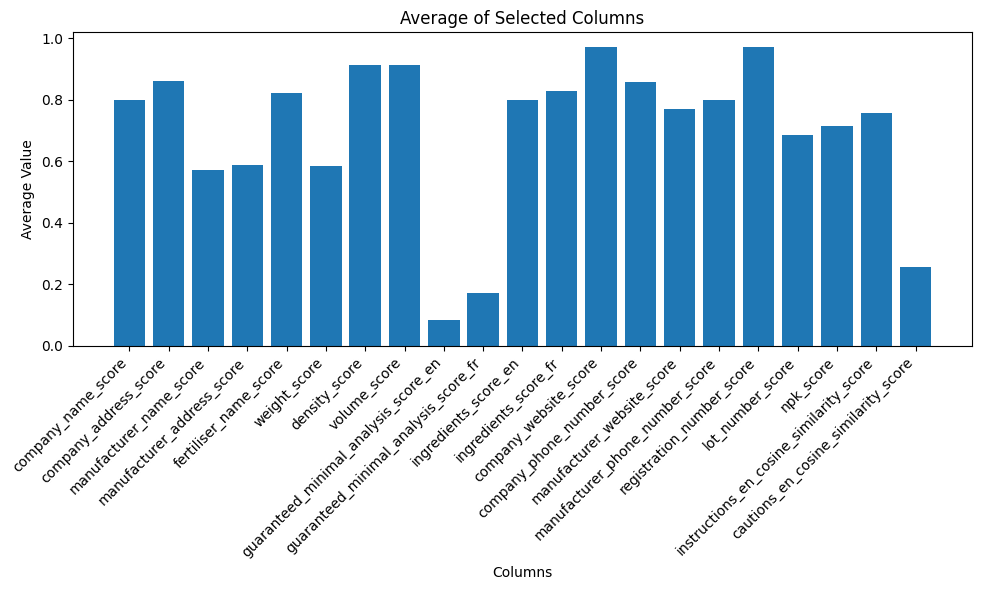

In [320]:
import matplotlib.pyplot as plt

score_columns = ['company_name_score', 'company_address_score', 'manufacturer_name_score', 'manufacturer_address_score', 'fertiliser_name_score', 'weight_score', 'density_score', 'volume_score', 'guaranteed_minimal_analysis_score_en', 'guaranteed_minimal_analysis_score_fr', 'ingredients_score_en', 'ingredients_score_fr', 'company_website_score', 'company_phone_number_score', 'manufacturer_website_score', 'manufacturer_phone_number_score', 'registration_number_score', 'lot_number_score', 'npk_score', 'instructions_en_cosine_similarity_score', 'cautions_en_cosine_similarity_score']

averages = dataset[score_columns].mean()

# Plot the averages as a bar plot
plt.figure(figsize=(10, 6))

plt.bar(averages.index, averages.values)

plt.xticks(rotation=45, ha='right')

plt.xlabel('Columns')
plt.ylabel('Average Value')
plt.title('Average of Selected Columns')
plt.tight_layout()

plt.show()

## calculating avg score per row

In [153]:
def calc_average_score_per_row(row, score_columns):
    score = 0
    count = 0
    for column in score_columns:
        if pd.isna(row[column]):
            continue
        score += row[column]
        count += 1
    return score / count if count > 0 else 0

dataset['average_score'] = dataset.apply(lambda row: calc_average_score_per_row(row, score_columns), axis=1)

In [157]:
dataset['average_score'].mean()

np.float64(0.5794859368725439)

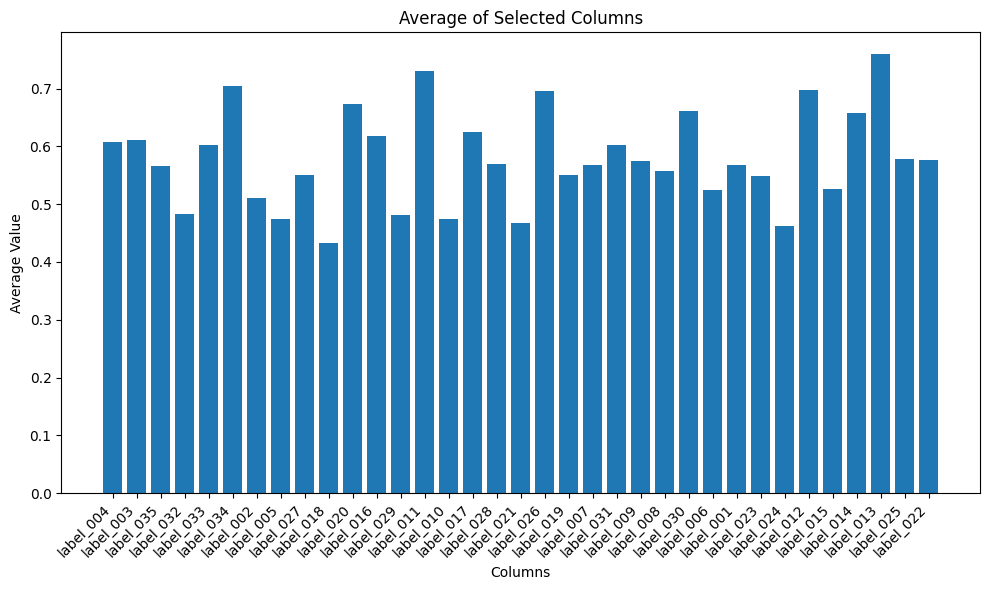

In [155]:
# avg_score = dataset['average_score'].mean()

# Plot the averages as a bar plot
plt.figure(figsize=(10, 6))

plt.bar(dataset['instance_path'], dataset['average_score'])

plt.xticks(rotation=45, ha='right')

plt.xlabel('Columns')
plt.ylabel('Average Value')
plt.title('Average of Selected Columns')
plt.tight_layout()

plt.show()

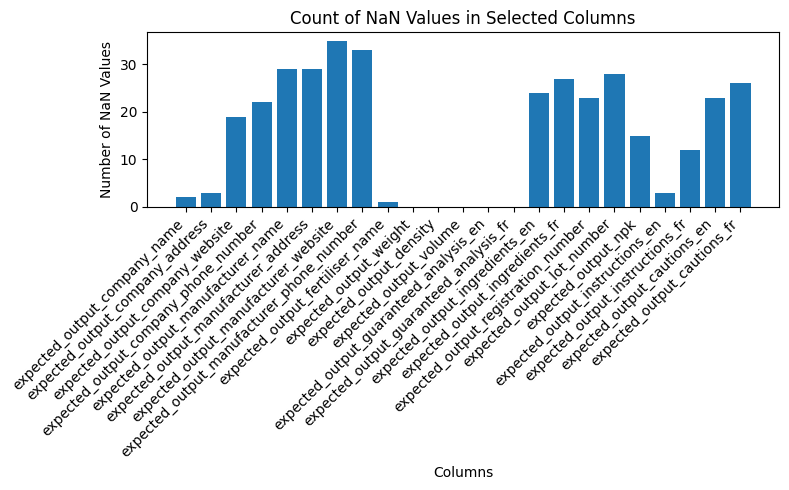

In [139]:
output_columns = ['expected_output_company_name', 'expected_output_company_address', 'expected_output_company_website', 'expected_output_company_phone_number', 'expected_output_manufacturer_name', 'expected_output_manufacturer_address', 'expected_output_manufacturer_website', 'expected_output_manufacturer_phone_number', 'expected_output_fertiliser_name', 'expected_output_weight', 'expected_output_density', 'expected_output_volume', 'expected_output_guaranteed_analysis_en', 'expected_output_guaranteed_analysis_fr', 'expected_output_ingredients_en', 'expected_output_ingredients_fr', 'expected_output_registration_number', 'expected_output_lot_number', 'expected_output_npk', 'expected_output_instructions_en', 'expected_output_instructions_fr', 'expected_output_cautions_en', 'expected_output_cautions_fr']
# len(output_columns) #should be 23

nan_counts = dataset[output_columns].isna().sum()
plt.figure(figsize=(8, 5))

# Plot the NaN counts as a bar plot
plt.bar(nan_counts.index, nan_counts.values)

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.title('Count of NaN Values in Selected Columns')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()

In [170]:
dataset[['instance_path', 'guaranteed_minimal_analysis_score_en', 'expected_output_guaranteed_analysis_en', 'dspy_output_guaranteed_analysis_en']]

,instance_path,guaranteed_minimal_analysis_score_en,expected_output_guaranteed_analysis_en,dspy_output_guaranteed_analysis_en
0,label_004,0,"{'title': 'Guaranteed Analysis', 'nutrients': [{'nutrient': 'Total Nitrogen (N)', 'value': 8, 'unit': '%'}, {'nutrient': 'Available Phosphate (P2O5)', 'value': 16, 'unit': '%'}, {'nutrient': 'Soluble Potash (K2O)', 'value': 8, 'unit': '%'}]}","{'title': 'Guaranteed Minimum Analysis', 'nutrients': [{'nutrient': 'Total Nitrogen (N)', 'value': 0.8, 'unit': '%'}, {'nutrient': 'Available Phosphate (P2O2)', 'value': 0.16, 'unit': '%'}, {'nutrient': 'Soluble Potash (K2O)', 'value': 8.0, 'unit': '%'}], 'is_minimal': True}"
1,label_003,0,"{'title': 'Guaranteed Analysis', 'nutrients': [{'nutrient': 'Total Nitrogen (N)', 'value': 15, 'unit': '%'}, {'nutrient': 'Available Phosphate (P2O5)', 'value': 22, 'unit': '%'}, {'nutrient': 'Soluble Potash (K2O)', 'value': 6, 'unit': '%'}, {'nutrient': 'Magnesium (Mg)', 'value': 1.21, 'unit': '%'}, {'nutrient': 'Boron (B)', 'value': 0.12, 'unit': '%'}, {'nutrient': 'Sulfur (S)', 'value': 6.3...",None
2,label_035,0,"{'title': 'GUARANTEED MINIMUM ANALYSIS', 'nutrients': [{'nutrient': 'Total nitrogen (N)', 'value': 0.6, 'unit': '%'}, {'nutrient': 'Available phosphoric acid (P2O5)', 'value': 1.8, 'unit': '%'}, {'nutrient': 'Soluble potash (K2O)', 'value': 0.1, 'unit': '%'}, {'nutrient': 'Calcium (Ca)', 'value': 14, 'unit': '%'}, {'nutrient': 'Magnesium (Mg)', 'value': 0.2, 'unit': '%'}, {'nutrient': 'Organic...","{'title': 'GUARANTEED MINIMUM ANALYSIS', 'nutrients': [{'nutrient': 'Total nitrogen (N)', 'value': 0.6, 'unit': '%'}, {'nutrient': 'Available phosphoric acid (P.O.)', 'value': 1.8, 'unit': '%'}, {'nutrient': 'Solube potash (K,O)', 'value': 0.1, 'unit': '%'}, {'nutrient': 'Calcium (Ca)', 'value': 14.0, 'unit': '%'}, {'nutrient': 'Magnesium (Mg)', 'value': 0.2, 'unit': '%'}, {'nutrient': 'Organi..."
3,label_032,0,"{'title': None, 'nutrients': None}",None
4,label_033,0,"{'title': 'GUARANTEED MINIMUM ANALYSIS', 'nutrients': [{'nutrient': 'Total nitrogen (N)', 'value': 2, 'unit': '%'}, {'nutrient': 'Water insoluble nitrogen', 'value': 2, 'unit': '%'}, {'nutrient': 'Available phosphoric acid (P2O5)', 'value': 14, 'unit': '%'}, {'nutrient': 'Calcium (Ca)', 'value': 25, 'unit': '%'}, {'nutrient': 'Organic matter', 'value': 25, 'unit': '%'}]}","{'title': 'GUARANTEED MINIMUM ANALYSIS', 'nutrients': [{'nutrient': 'Total nitrogen (N)', 'value': 2.0, 'unit': '%'}, {'nutrient': 'Water insoluble nitrogen', 'value': 2.0, 'unit': '%'}, {'nutrient': 'Available phosphoric acid (P.O.)', 'value': 14.0, 'unit': '%'}, {'nutrient': 'Calcium (Ca)', 'value': 25.0, 'unit': '%'}, {'nutrient': 'Organic matter', 'value': 25.0, 'unit': '%'}], 'is_minimal'..."
5,label_034,0,"{'title': 'GUARANTEED ANALYSIS', 'nutrients': [{'nutrient': 'Total Nitrogen (N)', 'value': 1, 'unit': '%'}, {'nutrient': 'Nitrate Nitrogen', 'value': 1, 'unit': '%'}, {'nutrient': 'Available Phosphate (P2O5)', 'value': 5, 'unit': '%'}, {'nutrient': 'Soluble Potash (K2O)', 'value': 4, 'unit': '%'}, {'nutrient': 'Magnesium (Mg)', 'value': 1, 'unit': '%'}, {'nutrient': 'Water Soluble Magnesium (M...","{'title': 'GUARANTEED ANALYSIS', 'nutrients': [{'nutrient': 'Total Nitrogen (N)', 'value': 1.0, 'unit': '%'}, {'nutrient': 'Nitrate Nitrogen', 'value': 1.0, 'unit': '%'}, {'nutrient': 'Available Phosphate (P205)', 'value': 5.0, 'unit': '%'}, {'nutrient': 'Soluble Potash (K20)', 'value': 4.0, 'unit': '%'}, {'nutrient': 'Magnesium (Mg)', 'value': 1.0, 'unit': '%'}, {'nutrient': 'Water Soluble Ma..."
6,label_002,0,"{'title': 'Guaranteed Analysis', 'nutrients': [{'nutrient': 'Boron', 'value': 10, 'unit': '%'}]}","{'title': 'GUARANTEED ANALYSIS', 'nutrients': [{'nutrient': 'Boron (B) (Actual)', 'value': 10.0, 'unit': '%'}], 'is_minimal': False}"
7,label_005,0,"{'title': 'Guaranteed Analysis', 'nutrients': [{'nutrient': 'Soluble potash', 'value': 3, 'unit': '%'}, {'nutrient': 'Calcium', 'value': 6, 'unit': '%'}, {'nutrient': 'Av

In [ ]:
dataset[]

# visualization

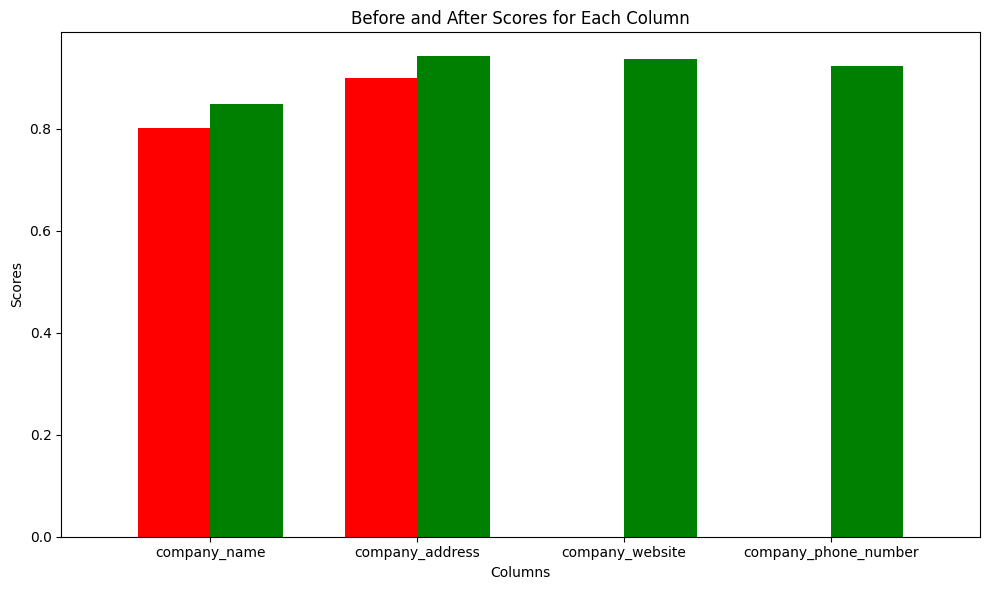

In [295]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Example DataFrame with before and after scores for each column
data = {
    'company_name': {'before': score_df['company_name_score_before'].mean(), 'after': score_df['company_name_score_after'].mean()},
    'company_address': {'before': score_df['company_address_score_before'].mean(), 'after': score_df['company_address_score_after'].mean()},
    'company_website': {'before': score_df['company_website_score_before'].mean(), 'after': score_df['company_website_score_after'].mean()},
    'company_phone_number': {'before': score_df['company_phone_number_score_before'].mean(), 'after': score_df['company_phone_number_score_after'].mean()},
}

# Convert to a DataFrame
df = pd.DataFrame(data)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set the positions for the bar plots
x = np.arange(len(df.columns))  # Position for each column
width = 0.35  # Width of the bars

# Loop through the columns and plot before and after scores
for i, column in enumerate(df.columns):
    ax.bar(x[i] - width/2, df[column]['before'], width, label=f'{column} before', color='r')
    ax.bar(x[i] + width/2, df[column]['after'], width, label=f'{column} after', color='g')

# Set the X axis labels to be the column names
ax.set_xticks(x)
ax.set_xticklabels(df.columns)

# Add labels and title
ax.set_xlabel('Columns')
ax.set_ylabel('Scores')
ax.set_title('Before and After Scores for Each Column')

# Add some space between groups of bars (optional)
ax.margins(x=0.1)

# Show the plot
plt.tight_layout()
plt.show()


# Further analysis based on the scores to double check some things

## fertiliser name

In [301]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 85 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   instance_path                                      35 non-null     object 
 1   image_files                                        35 non-null     object 
 2   expected_output                                    35 non-null     object 
 3   dspy_output                                        35 non-null     object 
 4   expected_output_company_name                       33 non-null     object 
 5   expected_output_company_address                    32 non-null     object 
 6   expected_output_company_website                    16 non-null     object 
 7   expected_output_company_phone_number               13 non-null     object 
 8   expected_output_manufacturer_name                  6 non-null      object 
 9   expected_out

In [302]:
dataset[dataset['expected_output_fertiliser_name'].isna()][['instance_path', 'expected_output_fertiliser_name', 'dspy_output_fertiliser_name']]

,instance_path,expected_output_fertiliser_name,dspy_output_fertiliser_name
1,label_003,None,15-22-6 vedette


In [303]:
dataset[dataset['dspy_output_fertiliser_name'].isna()][['instance_path', 'expected_output_fertiliser_name', 'dspy_output_fertiliser_name']]

,instance_path,expected_output_fertiliser_name,dspy_output_fertiliser_name
8,label_027,15-5-15 40% LENT 1.5 MG 3s .3ZN .3MN,None


In [304]:
dataset[(dataset['expected_output_fertiliser_name'].notna()) & (dataset['dspy_output_fertiliser_name'].notna()) & (dataset['expected_output_fertiliser_name'] == dataset['dspy_output_fertiliser_name'])][['instance_path', 'expected_output_fertiliser_name', 'dspy_output_fertiliser_name']]

,instance_path,expected_output_fertiliser_name,dspy_output_fertiliser_name
5,label_034,Overdrive,Overdrive
10,label_020,NOUSBO COAT (Fertilizer Coating Supplement),NOUSBO COAT (Fertilizer Coating Supplement)
11,label_016,BORE 15% GRANULAIRE / GRANULAR BORCH 15%,BORE 15% GRANULAIRE / GRANULAR BORCH 15%
18,label_026,Granular Ulexite,Granular Ulexite
21,label_031,WAVE,WAVE
24,label_030,Micronutrient Corn Mix Mélange d'oligoéléments pour maïs,Micronutrient Corn Mix Mélange d'oligoéléments pour maïs
25,label_006,Active MANGANESE™ 7% Mn,Active MANGANESE™ 7% Mn
33,label_025,Balancer,Balancer


In [ ]:
dataset[(dataset['expected_output_fertiliser_name'].notna()) & (dataset['dspy_output_fertiliser_name'].notna()) & (dataset['expected_output_fertiliser_name_cleaned'] == dataset['dspy_output_fertiliser_name_cleaned'])][['instance_path', 'expected_output_fertiliser_name', 'dspy_output_fertiliser_name']]

In [307]:
dataset[(dataset['expected_output_fertiliser_name'].notna()) & (dataset['dspy_output_fertiliser_name'].notna()) & (dataset['expected_output_fertiliser_name_preprocessed'] != dataset['dspy_output_fertiliser_name_preprocessed'])][['instance_path', 'expected_output_fertiliser_name', 'dspy_output_fertiliser_name', 'expected_output_fertiliser_name_preprocessed', 'dspy_output_fertiliser_name_preprocessed']]

,instance_path,expected_output_fertiliser_name,dspy_output_fertiliser_name,expected_output_fertiliser_name_preprocessed,dspy_output_fertiliser_name_preprocessed
2,label_035,Bionik,Bionik Marine & Forest Compost,bionik,bionik marine forest compost
3,label_032,9-11-12 3mg PLANTAMAX,Engrais minéraux Fertilize,91112 3mg plantamax,engrais minéraux fertilize
4,label_033,Unijardin,Unjardin,unijardin,unjardin
9,label_018,nitroGROW,Lawn Soil,nitrogrow,lawn soil
12,label_029,BIO 4-3-2 COMPOSYN 7% CA 0.6%MG,BIO 4-3-2 COMPOSYN,bio 432 composyn 7 ca 06mg,bio 432 composyn
13,label_011,Accelerate™,Accelerate™M,accelerate,acceleratem
14,label_010,Heat-Treated Pellets,DRY BLENDED FERTILIZER,heattreated pellets,dry blended fertilizer
17,label_021,FISH HYDROLYSATE,BIGBLUE,fish hydrolysate,bigblue
19,label_019,PowerCoat Microbial Inoculant,Powertoal® Microbial Inoculant,powercoat microbial inoculant,powertoal microbial inoculant
22,label_009,75% FMS Extended™,75% FMS Extended™ TM,75 fms extended,75 fms extended tm


In [308]:
dataset[['instance_path', 'expected_output_fertiliser_name', 'dspy_output_fertiliser_name', 'expected_output_fertiliser_name_preprocessed', 'dspy_output_fertiliser_name_preprocessed', 'fertiliser_name_score']]

,instance_path,expected_output_fertiliser_name,dspy_output_fertiliser_name,expected_output_fertiliser_name_preprocessed,dspy_output_fertiliser_name_preprocessed,fertiliser_name_score
0,label_004,Monty's 8-16-8,MONTY'S 8-16-8,montys 8168,montys 8168,1.000000
1,label_003,None,15-22-6 vedette,None,15226 vedette,NaN
2,label_035,Bionik,Bionik Marine & Forest Compost,bionik,bionik marine forest compost,0.842857
3,label_032,9-11-12 3mg PLANTAMAX,Engrais minéraux Fertilize,91112 3mg plantamax,engrais minéraux fertilize,0.503644
4,label_033,Unijardin,Unjardin,unijardin,unjardin,0.970370
5,label_034,Overdrive,Overdrive,overdrive,overdrive,1.000000
6,label_002,Bore 10%,BORE 10%,bore 10,bore 10,1.000000
7,label_005,Bean Promoter,BEAN PROMOTER,bean promoter,bean promoter,1.000000
8,label_027,15-5-15 40% LENT 1.5 MG 3s .3ZN .3MN,None,15515 40 lent 15 mg 3s 3zn 3mn,None,0.000000
9,label_018,nitroGROW,Lawn Soil,nitrogrow,lawn soil,0.481481


In [321]:
dataset[['instance_path', 'company_name_score', 'company_address_score', 'manufacturer_name_score',
       'manufacturer_address_score', 'fertiliser_name_score', 'weight_score',
       'density_score', 'volume_score', 'guaranteed_minimal_analysis_score_en',
       'guaranteed_minimal_analysis_score_fr', 'ingredients_score_en',
       'ingredients_score_fr', 'company_phone_number_score',
       'manufacturer_phone_number_score', 'company_website_score',
       'manufacturer_website_score', 'registration_number_score',
       'lot_number_score', 'npk_score',
       'expected_output_instructions_en_preprocessed',
       'dspy_output_instructions_en_preprocessed',
       'instructions_en_cosine_similarity_score',
       'expected_output_cautions_en_preprocessed',
       'dspy_output_cautions_en_preprocessed',
       'cautions_en_cosine_similarity_score']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 26 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   instance_path                                 35 non-null     object 
 1   company_name_score                            35 non-null     float64
 2   company_address_score                         35 non-null     float64
 3   manufacturer_name_score                       35 non-null     float64
 4   manufacturer_address_score                    35 non-null     float64
 5   fertiliser_name_score                         35 non-null     float64
 6   weight_score                                  35 non-null     float64
 7   density_score                                 35 non-null     int64  
 8   volume_score                                  35 non-null     int64  
 9   guaranteed_minimal_analysis_score_en          35 non-null     int64

In [322]:
dataset.columns

Index(['instance_path', 'image_files', 'expected_output', 'dspy_output',
       'expected_output_company_name', 'expected_output_company_address',
       'expected_output_company_website',
       'expected_output_company_phone_number',
       'expected_output_manufacturer_name',
       'expected_output_manufacturer_address',
       'expected_output_manufacturer_website',
       'expected_output_manufacturer_phone_number',
       'expected_output_fertiliser_name',
       'expected_output_registration_number', 'expected_output_lot_number',
       'expected_output_weight', 'expected_output_density',
       'expected_output_volume', 'expected_output_npk',
       'expected_output_guaranteed_analysis_en',
       'expected_output_guaranteed_analysis_fr',
       'expected_output_ingredients_en', 'expected_output_ingredients_fr',
       'expected_output_cautions_en', 'expected_output_cautions_fr',
       'expected_output_instructions_en', 'expected_output_instructions_fr',
       'dspy_output_c

In [325]:
dataset[['instance_path', 'expected_output_guaranteed_analysis_en', 'dspy_output_guaranteed_analysis_en', 'guaranteed_minimal_analysis_score_en']]

,instance_path,expected_output_guaranteed_analysis_en,dspy_output_guaranteed_analysis_en,guaranteed_minimal_analysis_score_en
0,label_004,"{'title': 'Guaranteed Analysis', 'nutrients': [{'nutrient': 'Total Nitrogen (N)', 'value': 8, 'unit': '%'}, {'nutrient': 'Available Phosphate (P2O5)', 'value': 16, 'unit': '%'}, {'nutrient': 'Soluble Potash (K2O)', 'value': 8, 'unit': '%'}]}","{'title': 'Guaranteed Minimum Analysis', 'nutrients': [{'nutrient': 'Total Nitrogen (N)', 'value': 0.8, 'unit': '%'}, {'nutrient': 'Available Phosphate (P2O2)', 'value': 0.16, 'unit': '%'}, {'nutrient': 'Soluble Potash (K2O)', 'value': 8.0, 'unit': '%'}], 'is_minimal': True}",0
1,label_003,"{'title': 'Guaranteed Analysis', 'nutrients': [{'nutrient': 'Total Nitrogen (N)', 'value': 15, 'unit': '%'}, {'nutrient': 'Available Phosphate (P2O5)', 'value': 22, 'unit': '%'}, {'nutrient': 'Soluble Potash (K2O)', 'value': 6, 'unit': '%'}, {'nutrient': 'Magnesium (Mg)', 'value': 1.21, 'unit': '%'}, {'nutrient': 'Boron (B)', 'value': 0.12, 'unit': '%'}, {'nutrient': 'Sulfur (S)', 'value': 6.3...",None,0
2,label_035,"{'title': 'GUARANTEED MINIMUM ANALYSIS', 'nutrients': [{'nutrient': 'Total nitrogen (N)', 'value': 0.6, 'unit': '%'}, {'nutrient': 'Available phosphoric acid (P2O5)', 'value': 1.8, 'unit': '%'}, {'nutrient': 'Soluble potash (K2O)', 'value': 0.1, 'unit': '%'}, {'nutrient': 'Calcium (Ca)', 'value': 14, 'unit': '%'}, {'nutrient': 'Magnesium (Mg)', 'value': 0.2, 'unit': '%'}, {'nutrient': 'Organic...","{'title': 'GUARANTEED MINIMUM ANALYSIS', 'nutrients': [{'nutrient': 'Total nitrogen (N)', 'value': 0.6, 'unit': '%'}, {'nutrient': 'Available phosphoric acid (P.O.)', 'value': 1.8, 'unit': '%'}, {'nutrient': 'Solube potash (K,O)', 'value': 0.1, 'unit': '%'}, {'nutrient': 'Calcium (Ca)', 'value': 14.0, 'unit': '%'}, {'nutrient': 'Magnesium (Mg)', 'value': 0.2, 'unit': '%'}, {'nutrient': 'Organi...",0
3,label_032,"{'title': None, 'nutrients': None}",None,1
4,label_033,"{'title': 'GUARANTEED MINIMUM ANALYSIS', 'nutrients': [{'nutrient': 'Total nitrogen (N)', 'value': 2, 'unit': '%'}, {'nutrient': 'Water insoluble nitrogen', 'value': 2, 'unit': '%'}, {'nutrient': 'Available phosphoric acid (P2O5)', 'value': 14, 'unit': '%'}, {'nutrient': 'Calcium (Ca)', 'value': 25, 'unit': '%'}, {'nutrient': 'Organic matter', 'value': 25, 'unit': '%'}]}","{'title': 'GUARANTEED MINIMUM ANALYSIS', 'nutrients': [{'nutrient': 'Total nitrogen (N)', 'value': 2.0, 'unit': '%'}, {'nutrient': 'Water insoluble nitrogen', 'value': 2.0, 'unit': '%'}, {'nutrient': 'Available phosphoric acid (P.O.)', 'value': 14.0, 'unit': '%'}, {'nutrient': 'Calcium (Ca)', 'value': 25.0, 'unit': '%'}, {'nutrient': 'Organic matter', 'value': 25.0, 'unit': '%'}], 'is_minimal'...",0
5,label_034,"{'title': 'GUARANTEED ANALYSIS', 'nutrients': [{'nutrient': 'Total Nitrogen (N)', 'value': 1, 'unit': '%'}, {'nutrient': 'Nitrate Nitrogen', 'value': 1, 'unit': '%'}, {'nutrient': 'Available Phosphate (P2O5)', 'value': 5, 'unit': '%'}, {'nutrient': 'Soluble Potash (K2O)', 'value': 4, 'unit': '%'}, {'nutrient': 'Magnesium (Mg)', 'value': 1, 'unit': '%'}, {'nutrient': 'Water Soluble Magnesium (M...","{'title': 'GUARANTEED ANALYSIS', 'nutrients': [{'nutrient': 'Total Nitrogen (N)', 'value': 1.0, 'unit': '%'}, {'nutrient': 'Nitrate Nitrogen', 'value': 1.0, 'unit': '%'}, {'nutrient': 'Available Phosphate (P205)', 'value': 5.0, 'unit': '%'}, {'nutrient': 'Soluble Potash (K20)', 'value': 4.0, 'unit': '%'}, {'nutrient': 'Magnesium (Mg)', 'value': 1.0, 'unit': '%'}, {'nutrient': 'Water Soluble Ma...",0
6,label_002,"{'title': 'Guaranteed Analysis', 'nutrients': [{'nutrient': 'Boron', 'value': 10, 'unit': '%'}]}","{'title': 'GUARANTEED ANALYSIS', 'nutrients': [{'nutrient': 'Boron (B) (Actual)', 'value': 10.0, 'unit': '%'}], 'is_minimal': False}",0
7,label_005,"{'title': 'Guaranteed Analysis', 'nutrients': [{'nutrient': 'Soluble potash', 'value': 3, 'unit': '%'}, {'nutrient': 'Calcium', 'value': 6, 'unit': '%'}, {'nutrient': 'Avai